## Load data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
import warnings

In [ ]:
warnings.simplefilter(action= 'ignore')

In [ ]:
np.random.seed(42)

In [ ]:
categories = pd.read_csv('item_categories.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sales = pd.read_csv('sales_train.csv')

## Look at the data

In [ ]:
shops.head(3)

shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1
2               Адыгея ТЦ "Мега"        2

In [ ]:
categories.head(3)

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2

In [ ]:
items.head(3)

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   

   item_category_id  
0                40  
1                76  
2                40

In [ ]:
sales.head(3)

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2552       899.0           1.0
2  05.01.2013               0       25     2552       899.0          -1.0

## Checking NaN

In [ ]:
shops.isna().sum(), items.isna().sum(), categories.isna().sum(), sales.isna().sum()

(shop_name    0
 shop_id      0
 dtype: int64, item_name           0
 item_id             0
 item_category_id    0
 dtype: int64, item_category_name    0
 item_category_id      0
 dtype: int64, date              0
 date_block_num    0
 shop_id           0
 item_id           0
 item_price        0
 item_cnt_day      0
 dtype: int64)

There are no NaN values

# Check common sense

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


The fact that item_cnt_day has the type float is kind of suspicios. It might be a sign of existing outliers

In [ ]:
sales[sales.item_cnt_day != round(sales.item_cnt_day)]

Empty DataFrame
Columns: [date, date_block_num, shop_id, item_id, item_price, item_cnt_day]
Index: []

There are no float values so let's transform float -> int

In [ ]:
sales.item_cnt_day = sales.item_cnt_day.astype(int)

In [ ]:
sales.describe(percentiles=[.25, .5, .75, .95]).drop(['shop_id', 'item_id'], axis = 1)

date_block_num    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  8.908532e+02  1.242641e+00
std      9.422988e+00  1.729800e+03  2.618834e+00
min      0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.990000e+02  1.000000e+00
75%      2.300000e+01  9.990000e+02  1.000000e+00
95%      3.100000e+01  2.690000e+03  2.000000e+00
max      3.300000e+01  3.079800e+05  2.169000e+03

Noticing some suspicios numbers in 'min' row

In [ ]:
sales[sales.item_price <= 0]

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
484683  15.05.2013               4       32     2973        -1.0             1

In [ ]:
len(sales[sales.item_cnt_day < 0])

7356

There are some incorrect values in 'item_price' and 'item_cnt_day'. As a solution we can erase all the outliers or make the negative count positive assuming the minus appeard just by mistake

# Shops

In [ ]:
shops.sample(3)

shop_name  shop_id
0           !Якутск Орджоникидзе, 56 фран        0
5                  Вологда ТРЦ "Мармелад"        5
36  Новосибирск ТРЦ "Галерея Новосибирск"       36

In [ ]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [ ]:
shops.shop_id = shops.shop_id.astype(np.int8)

 It looks like the first word is the name of the city. Let's extract city name from shop name and see if it can help.

Also we see duplicates at indexes 0-58, 1-59 

In [ ]:
shops.iloc[0,0] = shops.iloc[0,0][1:]
shops.iloc[1,0] = shops.iloc[1,0][1:]
shops['city'] = [x.split(' ')[0] for x in shops.shop_name]
shops.sample(5)

shop_name  shop_id        city
18          Красноярск ТЦ "Июнь"       18  Красноярск
45          Самара ТЦ "ПаркХаус"       45      Самара
47        Сургут ТРЦ "Сити Молл"       47      Сургут
48  Томск ТРЦ "Изумрудный Город"       48       Томск
4       Волжский ТЦ "Волга Молл"        4    Волжский

In [ ]:
cities = pd.unique(shops['city'])
cities, len(cities)

(array(['Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
        'Выездная', 'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга',
        'Коломна', 'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
        'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
        'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
        'Ярославль'], dtype=object), 31)

We see that there are "Интернет-магазин", "Цифровой", "Выездная" which are obviously not cities. Let's leave it the way it is for now. Maybe it will not be a problem

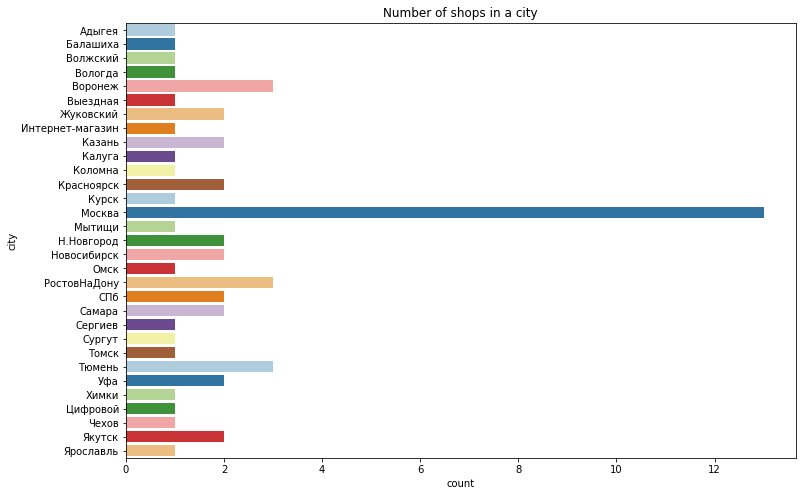

In [ ]:
plt.figure(figsize=(12,8))
sns.countplot(y="city", data=shops.iloc[2:], palette = 'Paired')
plt.title('Number of shops in a city')
plt.show()

It looks like Moscow has more shops than any other city

# Categories

In [ ]:
categories.sample(4)

item_category_name  item_category_id
20                         Игры - PS4                20
70     Подарки - Сувениры (в навеску)                70
52               Книги - Путеводители                52
49  Книги - Методические материалы 1С                49

In [ ]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [ ]:
categories.item_category_id = categories.item_category_id.astype(np.int8)

In [ ]:
len(pd.unique(categories['item_category_name']))

84

All the categories are unique. But there are a lot of them. If we look at the structure we'll see that most of the categories follow the pattern '1 - 2' where 2 is additional category

Let's extract category and subcategory and get rid of the words in braces as they also represent additional information which may be redundant to the model

In [ ]:
categories['cat'] = [x.split('-')[0].strip().split('(')[0].strip() for x in categories['item_category_name'] ]
categories['sub_cat'] = categories["item_category_name"].str.split(" - ").str.get(1).str.strip().fillna(categories['cat'])
categories['sub_cat'] = categories['sub_cat'].str.split('(').str.get(0).str.strip()
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita',
       'XBOX 360', 'XBOX ONE', 'Билеты', 'Доставка товара', 'Прочие',
       'Аксессуары для игр', 'Цифра', 'Дополнительные издания',
       'Коллекционные издания', 'Стандартные издания', 'Карты оплаты',
       'Live!', 'PSN', 'Windows', 'Blu-Ray', 'Blu-Ray 3D', 'Blu-Ray 4K',
       'DVD', 'Коллекционное', 'Артбуки, энциклопедии', 'Аудиокниги',
       'Аудиокниги 1С', 'Бизнес литература', 'Комиксы, манга',
       'Компьютерная литература', 'Методические материалы 1С', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Открытки, наклейки',
       'Развитие', 'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприяти

In [ ]:
categories['sub_cat'] = categories['sub_cat'].str.replace(' 360', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' ONE', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 3D', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 4K', '')
categories['sub_cat'] = categories['sub_cat'].str.replace(' 1С', '')

In [ ]:
pd.unique(categories.sub_cat)

array(['Гарнитуры/Наушники', 'PS2', 'PS3', 'PS4', 'PSP', 'PSVita', 'XBOX',
       'Билеты', 'Доставка товара', 'Прочие', 'Аксессуары для игр',
       'Цифра', 'Дополнительные издания', 'Коллекционные издания',
       'Стандартные издания', 'Карты оплаты', 'Live!', 'PSN', 'Windows',
       'Blu-Ray', 'DVD', 'Коллекционное', 'Артбуки, энциклопедии',
       'Аудиокниги', 'Бизнес литература', 'Комиксы, манга',
       'Компьютерная литература', 'Методические материалы', 'Открытки',
       'Познавательная литература', 'Путеводители',
       'Художественная литература', 'CD локального производства',
       'CD фирменного производства', 'MP3', 'Винил', 'Музыкальное видео',
       'Подарочные издания', 'Атрибутика', 'Гаджеты, роботы, спорт',
       'Мягкие игрушки', 'Настольные игры', 'Открытки, наклейки',
       'Развитие', 'Сертификаты, услуги', 'Сувениры',
       'Сумки, Альбомы, Коврики д/мыши', 'Фигурки', '1С:Предприятие 8',
       'MAC', 'Для дома и офиса', 'Обучающие', 'Служебные',
     

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Игры Android', 'Игры MAC', 'Игры PC', 'Карты оплаты',
       'Кино', 'Книги', 'Музыка', 'Подарки', 'Программы', 'Служебные',
       'Чистые носители', 'Элементы питания'], dtype=object)

Let's change all "Игры **** " to just "Игры" to simplify the categories

In [ ]:
categories['cat'] = ['Игры' if x == 'Игры PC' or x == 'Игры Android' or x == 'Игры MAC' else x for x in categories['cat']  ]
categories.sample(10)

item_category_name  item_category_id              cat  \
40                         Кино - DVD                40             Кино   
20                         Игры - PS4                20             Игры   
13              Игровые консоли - PSP                13  Игровые консоли   
29    Игры PC - Коллекционные издания                29             Игры   
7               Аксессуары - XBOX ONE                 7       Аксессуары   
73       Программы - 1С:Предприятие 8                73        Программы   
49  Книги - Методические материалы 1С                49            Книги   
3                    Аксессуары - PS4                 3       Аксессуары   
36     Карты оплаты - Windows (Цифра)                36     Карты оплаты   
14           Игровые консоли - PSVita                14  Игровые консоли   

                   sub_cat  
40                     DVD  
20                     PS4  
13                     PSP  
29   Коллекционные издания  
7                     XBOX  
73        1С:Предприятие 8  
49  Методические материалы  
3                      PS4  
36                 Windows  
14                  PSVita

Looks nice

In [ ]:
pd.unique(categories['cat'])

array(['PC', 'Аксессуары', 'Билеты', 'Доставка товара', 'Игровые консоли',
       'Игры', 'Карты оплаты', 'Кино', 'Книги', 'Музыка', 'Подарки',
       'Программы', 'Служебные', 'Чистые носители', 'Элементы питания'],
      dtype=object)

In [ ]:
len(categories), len(pd.unique(categories.sub_cat)), len(pd.unique(categories['cat']))

(84, 55, 15)

# Items

In [ ]:
items.sample(5)

item_name  item_id  \
12135  Игромания. Выбор редакции. Call of Duty: World...    12135   
5980   R.E.M.  Part Lies Part Heart Part Truth Part G...     5980   
2561   DEEP PURPLE In Rock - 25th Anniversary Edition...     2561   
17714  Практический годовой отчет за 2014 год (+ диск...    17714   
898              1С:Школа. Окружающий мир, 1-4 кл. Тесты      898   

       item_category_id  
12135                30  
5980                 55  
2561                 56  
17714                49  
898                  77

It looks like very few item names contain valid info about the category. So we'll leave it untouched for now

In [ ]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [ ]:
items.item_id = items.item_id.astype(np.int16)

In [ ]:
len(pd.unique(items.item_name))

22170

All the names are unique. There are no duplicates

# Sales

In [ ]:
sales.sample(7)

date  date_block_num  shop_id  item_id  item_price  \
2126242  20.11.2014              22       54    11795       139.3   
1204091  04.12.2013              11       54    12477       199.0   
2462910  03.02.2015              25       12    17957       699.0   
1961285  15.09.2014              20       42     2808       999.0   
933816   02.10.2013               9       44     8924       299.0   
2330000  09.01.2015              24       18    14831       999.0   
526141   21.05.2013               4        6    18298       199.0   

         item_cnt_day  
2126242             1  
1204091             1  
2462910            -1  
1961285             1  
933816              1  
2330000             1  
526141              1

In [ ]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    int64  
dtypes: float64(1), int64(4), object(1)
memory usage: 134.4+ MB


In [ ]:
sales.item_id = sales.item_id.astype(np.int16)
sales.shop_id = sales.shop_id.astype(np.int8)
sales.date_block_num = sales.date_block_num.astype(np.int8)
sales.item_cnt_day = sales.item_cnt_day.astype(np.int32)
sales.item_price = sales.item_price.astype(np.float32)

Let's change values in 'date' col from string to date type

In [ ]:
sales.date = pd.to_datetime(sales.date, format='%d.%m.%Y')
sales.sample()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
2123084 2014-11-01              22       31     5671      3190.0             2

In [ ]:
sales.item_price.describe(percentiles=[.25, .5, .75, .95])

count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
95%      2.690000e+03
max      3.079800e+05
Name: item_price, dtype: float64

It looks like 95% of items were sold for less than 2690 RUB considering max price is ~300.000 RUB

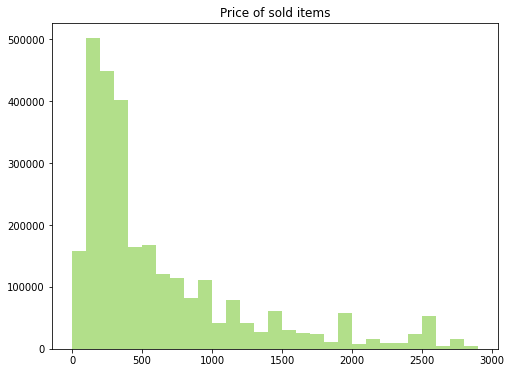

In [ ]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_price, color = colors, bins = list(range(0,3000, 100)))
plt.title('Price of sold items')
plt.show()

In [ ]:
sales['ln_price'] = np.log(sales.item_price)

In [ ]:
sales.ln_price.describe(percentiles=[.25, .5, .75, .95])

count    2.935848e+06
mean     6.155308e+00
std      1.147534e+00
min     -2.659260e+00
25%      5.517453e+00
50%      5.988961e+00
75%      6.906755e+00
95%      7.897296e+00
max      1.263779e+01
Name: ln_price, dtype: float64

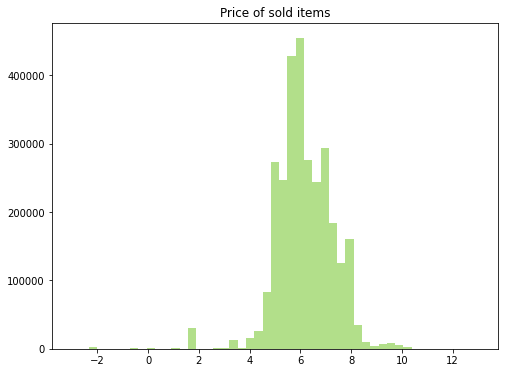

In [ ]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.ln_price, color = colors, bins = list(np.linspace(-3,13,50)))
plt.title('Price of sold items')
plt.show()

In [ ]:
sales.item_cnt_day.describe(percentiles=[.25, .5, .75, .875, .95])

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
87.5%    1.000000e+00
95%      2.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

It looks like most items were sold by <= 1 in a day and 95% were sold in less or equal than 2

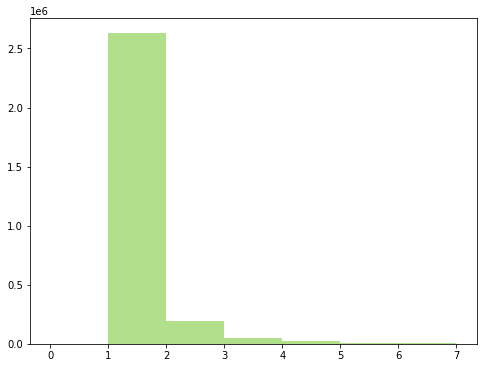

In [ ]:
plt.figure(figsize=(8,6))
colors = sns.color_palette('Paired')[2]
plt.hist(sales.item_cnt_day, color = colors, bins = list(range(0,8, 1)))
plt.show()

# Outliers

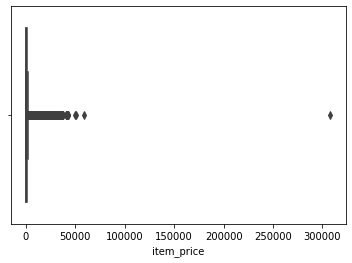

In [ ]:
sns.boxplot(sales.item_price)
plt.show()

In [ ]:
sales[sales.item_price >= 50000]

date  date_block_num  shop_id  item_id  item_price  \
885138  2013-09-17               8       12    11365     59200.0   
1163158 2013-12-13              11       12     6066    307980.0   
1488135 2014-03-20              14       25    13199     50999.0   

         item_cnt_day   ln_price  
885138              1  10.988677  
1163158             1  12.637790  
1488135             1  10.839561

In [ ]:
temp = sales.item_price.describe()
q25 = temp[4]
q75 = temp[6]
IQR = q75 - q25
Upper_bound = (1.5 * IQR) + q75
Lower_bound= q25 - (1.5 * IQR)

In [ ]:
sales[sales.item_price > Upper_bound ]

date  date_block_num  shop_id  item_id  item_price  \
37      2013-01-02               0       25     2719      2699.0   
38      2013-01-12               0       25     2719      2699.0   
158     2013-01-03               0       25     2253      2199.0   
159     2013-01-18               0       25     2253      2199.0   
160     2013-01-26               0       25     2254      2199.0   
...            ...             ...      ...      ...         ...   
2935782 2015-10-30              33       25     7134      3599.0   
2935802 2015-10-19              33       25     7583      2150.0   
2935804 2015-10-29              33       25     7610      2890.0   
2935813 2015-10-01              33       25     7640      4040.0   
2935822 2015-10-17              33       25     7632      2310.0   

         item_cnt_day  ln_price  
37                  1  7.900637  
38                  1  7.900637  
158                 1  7.695758  
159                 1  7.695758  
160                 1  7.695758  
...               ...       ...  
2935782             1  8.188412  
2935802             1  7.673223  
2935804             1  7.969012  
2935813             1  8.304000  
2935822             1  7.745003  

[258942 rows x 7 columns]

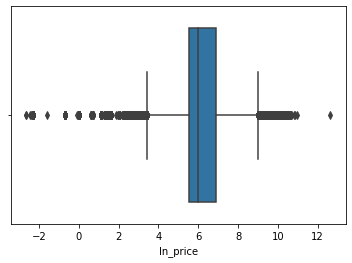

In [ ]:
sns.boxplot(sales.ln_price)

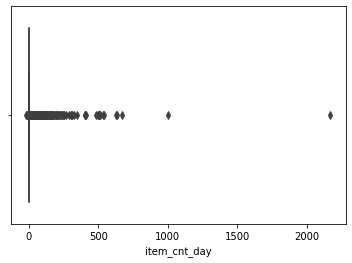

In [ ]:
sns.boxplot(sales.item_cnt_day)

In [ ]:
sales[sales.item_cnt_day > 20].groupby('date_block_num').groups.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

# Merge items with categories in order to proceed the analysis

In [ ]:
items_with_categories = pd.merge(items,categories, on = 'item_category_id')

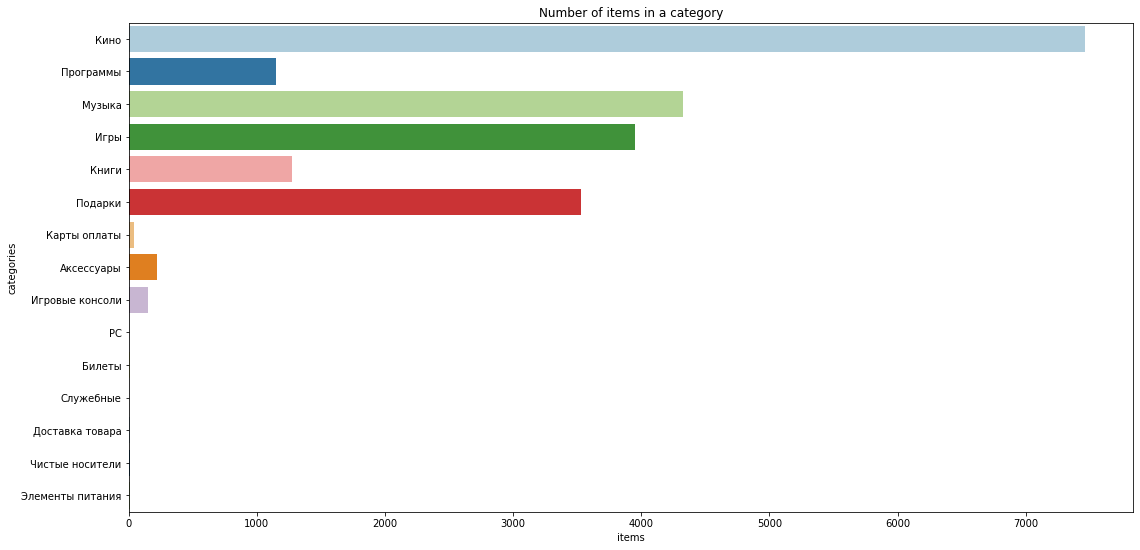

In [ ]:
fig = plt.figure(figsize=(18,9))
chart = sns.countplot(y="cat", data=items_with_categories, palette = 'Paired')
chart.set(xlabel='items', ylabel='categories')
plt.title('Number of items in a category')
plt.show()

It looks like most items from items dataset are labeled as "Кино". Some categories are represented by a very limited amount of items. Maybe it would make sense to unite them into one category like 'other' for simplification later

# Total sells in a city

In [ ]:
sales_shop = pd.merge(sales,shops, on = 'shop_id')
cities_total = sales_shop.groupby('city')['item_cnt_day'].sum()

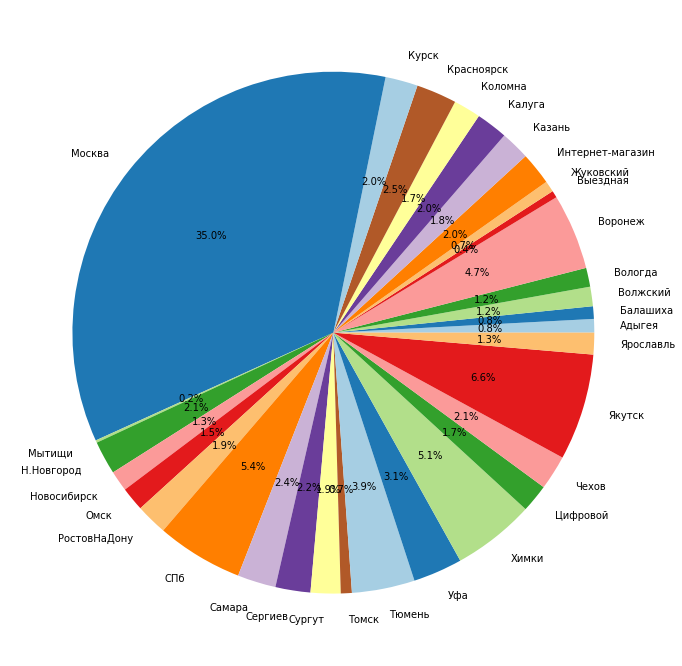

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total, labels = cities_total.index, autopct = '%0.1f%%', colors = colors)
plt.show()

As you can see from the pieplot Moscow is the leader. But Moscow also has much more shops than other cities. So let's take a look at the average count of items 

In [ ]:
shops_count = pd.DataFrame(shops.groupby('city')['shop_name'].count()).reset_index(level = [0])
cities_total =  pd.DataFrame(cities_total).reset_index(level = [0])
cities_total = pd.merge(shops_count, cities_total, on = 'city')
cities_total.columns = ['city', 'shop_count', 'item_cnt_month']
cities_total['mean'] = cities_total.item_cnt_month/cities_total.shop_count
cities_total.head()

city  shop_count  item_cnt_month          mean
0    Адыгея           1           30620  30620.000000
1  Балашиха           1           28355  28355.000000
2  Волжский           1           43942  43942.000000
3   Вологда           1           42762  42762.000000
4   Воронеж           3          171142  57047.333333

# Average amount of sold items in a city

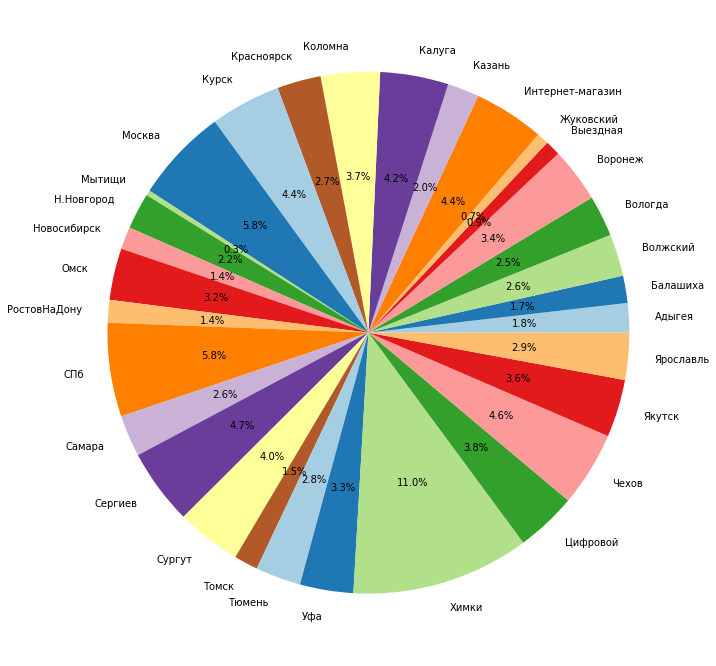

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cities_total)]
plt.pie(cities_total['mean'], labels = cities_total.city, autopct = '%0.1f%%', colors = colors)
plt.show()

From this pieplot Himky has more sold items in average. It has only one shop. 

Let's look at the amount of sold items per each shop

# Total sells in shops

In [ ]:
shops_total = sales_shop.groupby('shop_name')['item_cnt_day'].sum()

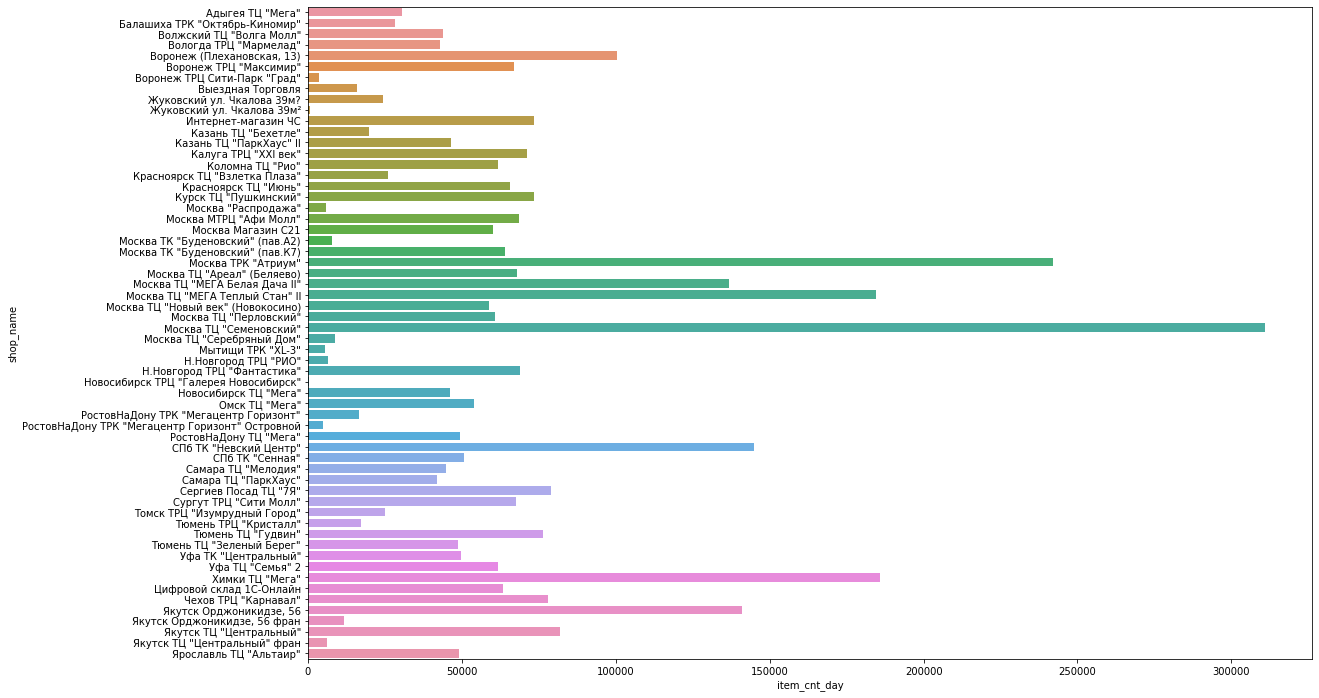

In [ ]:
fig = plt.figure(figsize=(18,12))
chart = sns.barplot(x = shops_total, y = shops_total.index)
plt.show()

We already saw the distribution of item_cnt_day.
Let's look at the distribution of sold items in a month

In [ ]:
fet = pd.DataFrame(sales.groupby([sales.date_block_num, 'item_id'])['item_cnt_day'].sum())
fet.index.names = ['month', 'item_id']
fet.columns = ['item_cnt_month']
fet = fet.reset_index(level = [0,1])

In [ ]:
fet[['item_cnt_month']].describe([.25, .5, .75, .95])

item_cnt_month
count   233912.000000
mean        15.596489
std         96.125890
min        -22.000000
25%          2.000000
50%          4.000000
75%         11.000000
95%         54.000000
max      12557.000000

We see that 95% of the items are sold in less than 54 and the mode is 1

Let's look at the distribution

# Which month is the most selling

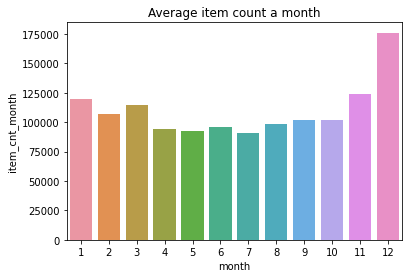

In [ ]:
m = [3,3,3,3,3,3,3,3,3,3,2,2]
mean_month = pd.DataFrame(sales.groupby(sales.date.dt.month)['item_cnt_day'].sum()/ m).reset_index(level = [0])
mean_month.columns = ['month', 'item_cnt_month']
sns.barplot(x='month', y='item_cnt_month', data=mean_month)
plt.title('Average item count a month')
plt.show()

December is clearly the 'leader'

# Fill missing months with 0


In [ ]:
it_index = []
sh_index = []
sh_len = len(shops)
date = []
for i in range(len(items)):
    it_index += [i]*(34 * sh_len)
    sh_index += list(range(sh_len))* 34
    for j in range(34):
        date += [j] * sh_len

In [ ]:
data = pd.merge(
    pd.DataFrame({
    'item_id' : it_index,
    'shop_id': sh_index,
    'date_block_num' : date
}), pd.DataFrame(sales.groupby(['item_id','shop_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1,2]),
 how = 'left', on = ['item_id','shop_id', 'date_block_num'] )
data = data.fillna(0)
data.columns = ['item_id', 'shop_id', 'date_block_num', 'item_cnt_month']
data.sample(10)

item_id  shop_id  date_block_num  item_cnt_month
8576538      4204       18               6             0.0
18451059     9044       39              21             0.0
21201972    10393       12               4             0.0
7717968      3783       48              10             0.0
5113622      2506        2              23             0.0
42884007    21021       27              19             0.0
11689899     5730       39              11             0.0
18613362     9124       42               6             0.0
36165726    17728        6              10             0.0
5722544      2805       44               5             0.0

In [ ]:
it_index = 0
sh_index = 0 
date = 0

In [ ]:
mean_price = sales.groupby(['item_id', 'shop_id', 'date_block_num'])['item_price'].mean().reset_index([0,1,2])
data = pd.merge(data, mean_price, on = ['item_id', 'shop_id', 'date_block_num'], how = 'left')

In [ ]:
mean_price_month = sales.groupby(['item_id', 'date_block_num'])[['item_price']].mean().reset_index([0,1])
mean_price_month.columns = ['item_id', 'date_block_num','mean_item_price']

In [ ]:
it_index = []
date = []
for i in range(len(items)):
    it_index += [i]*(34)
    date += list(range(34))

In [ ]:
mean_price_month = pd.merge(mean_price_month, pd.DataFrame({
    'item_id' : it_index,
    'date_block_num' : date}), on = ['item_id', 'date_block_num'], how = 'right')
it_index = 0
date = 0

In [ ]:
mean_price_month.mean_item_price = mean_price_month.groupby('item_id').mean_item_price.fillna(method = 'ffill') 
mean_price_month.mean_item_price = mean_price_month.groupby('item_id').mean_item_price.fillna(method = 'bfill') 

In [ ]:
data = pd.merge(data, mean_price_month, on = ['item_id', 'date_block_num'], how = 'left' )
data.item_price = data.item_price.fillna(data['mean_item_price'])
data = data.drop(['mean_item_price'], axis = 1)
data.isna().sum()

item_id                0
shop_id                0
date_block_num         0
item_cnt_month         0
item_price        740520
dtype: int64

This are the items that were not sold at all (new items)

In [ ]:
data.item_id = data.item_id.astype(np.int16)
data.shop_id = data.shop_id.astype(np.int8)
data.date_block_num = data.date_block_num.astype(np.int8)
data.item_cnt_month = data.item_cnt_month.astype(np.int32)
data.item_price = data.item_price.astype(np.float32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45226800 entries, 0 to 45226799
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   item_id         int16  
 1   shop_id         int8   
 2   date_block_num  int8   
 3   item_cnt_month  int32  
 4   item_price      float32
dtypes: float32(1), int16(1), int32(1), int8(2)
memory usage: 862.6 MB


# Merge all

In [ ]:
data = pd.merge(data, shops, on = 'shop_id')
data = pd.merge(data, items, on = 'item_id')
data = pd.merge(data, categories, on = 'item_category_id' )
len(data)

45226800

In [ ]:
data.item_category_id = data.item_category_id.astype(np.int8)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45226800 entries, 0 to 45226799
Data columns (total 12 columns):
 #   Column              Dtype  
---  ------              -----  
 0   item_id             int16  
 1   shop_id             int8   
 2   date_block_num      int8   
 3   item_cnt_month      int32  
 4   item_price          float32
 5   shop_name           object 
 6   city                object 
 7   item_name           object 
 8   item_category_id    int8   
 9   item_category_name  object 
 10  cat                 object 
 11  sub_cat             object 
dtypes: float32(1), int16(1), int32(1), int8(3), object(6)
memory usage: 2.9+ GB


Fill price for new items with the mean in a subcategory

In [ ]:
data['item_price'] = data['item_price'].fillna(data.groupby('sub_cat')['item_price'].transform('mean'))

In [ ]:
data.isna().sum()

item_id               0
shop_id               0
date_block_num        0
item_cnt_month        0
item_price            0
shop_name             0
city                  0
item_name             0
item_category_id      0
item_category_name    0
cat                   0
sub_cat               0
dtype: int64

In [ ]:
data['ln_price'] = np.log(data.item_price + 3)

# Most selling categories

In [ ]:
cat_total = data.groupby('cat')['item_cnt_month'].sum()

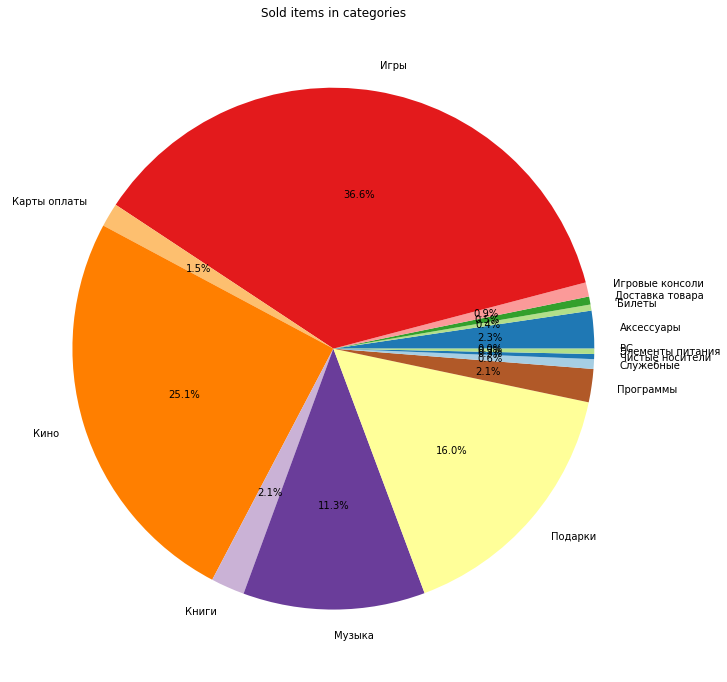

In [ ]:
plt.figure(figsize=(12,12))
colors = sns.color_palette('Paired')[:len(cat_total)]
plt.pie(cat_total, labels = cat_total.index, autopct = '%0.1f%%', colors = colors)
plt.title('Sold items in categories')
plt.show()

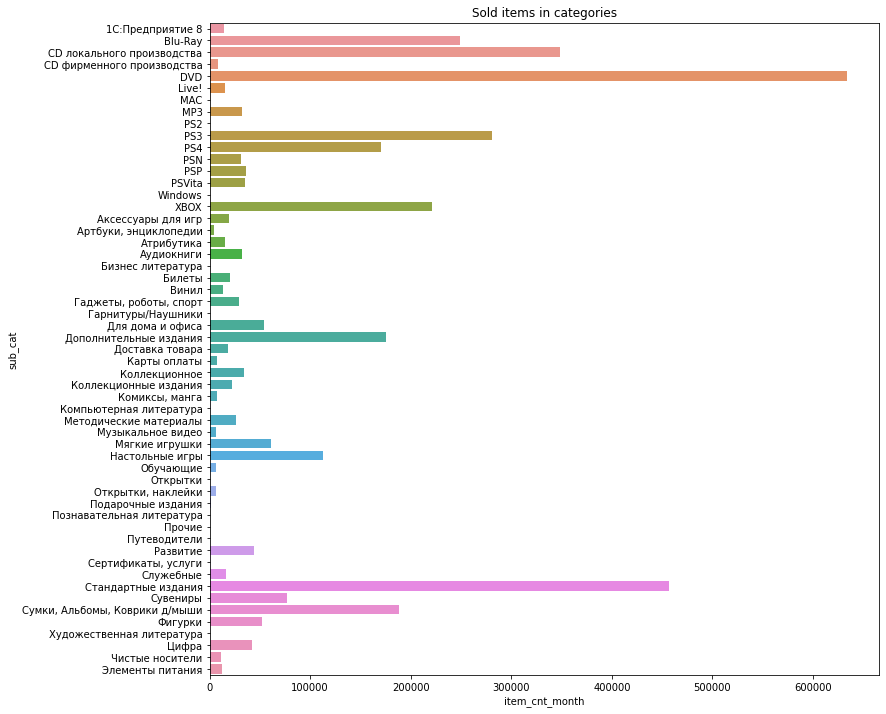

In [ ]:
cat_total = data.groupby('sub_cat')['item_cnt_month'].sum()
plt.figure(figsize=(12,12))
sns.barplot(x = cat_total, y = cat_total.index)
plt.title('Sold items in categories')
plt.show()

# Min, mean and max ln(price) 

In [ ]:
def min_max_cat(name):
    cat_price = data.groupby(name)['ln_price'].describe()
    cat_price = cat_price[['min','mean', 'max']]
    cat_price = cat_price.reset_index(level=[0])
    return cat_price

In [ ]:
cat_price = min_max_cat('cat')
sub_cat_price = min_max_cat('sub_cat')


In [ ]:
cats = pd.unique(categories.cat)
sub_cats = pd.unique(categories.sub_cat)

In [ ]:
def plot_cats(cat_price, categ, rows):
    plt.subplots_adjust(wspace = 2)
    for i in range(len(categ)):
        plt.subplot(rows,len(categ)//(rows - 1), i+1)
        sns.barplot(x = cat_price.columns[1:], y = cat_price.iloc[i,1:])
        plt.title(cat_price.iloc[i,0])
    plt.show()

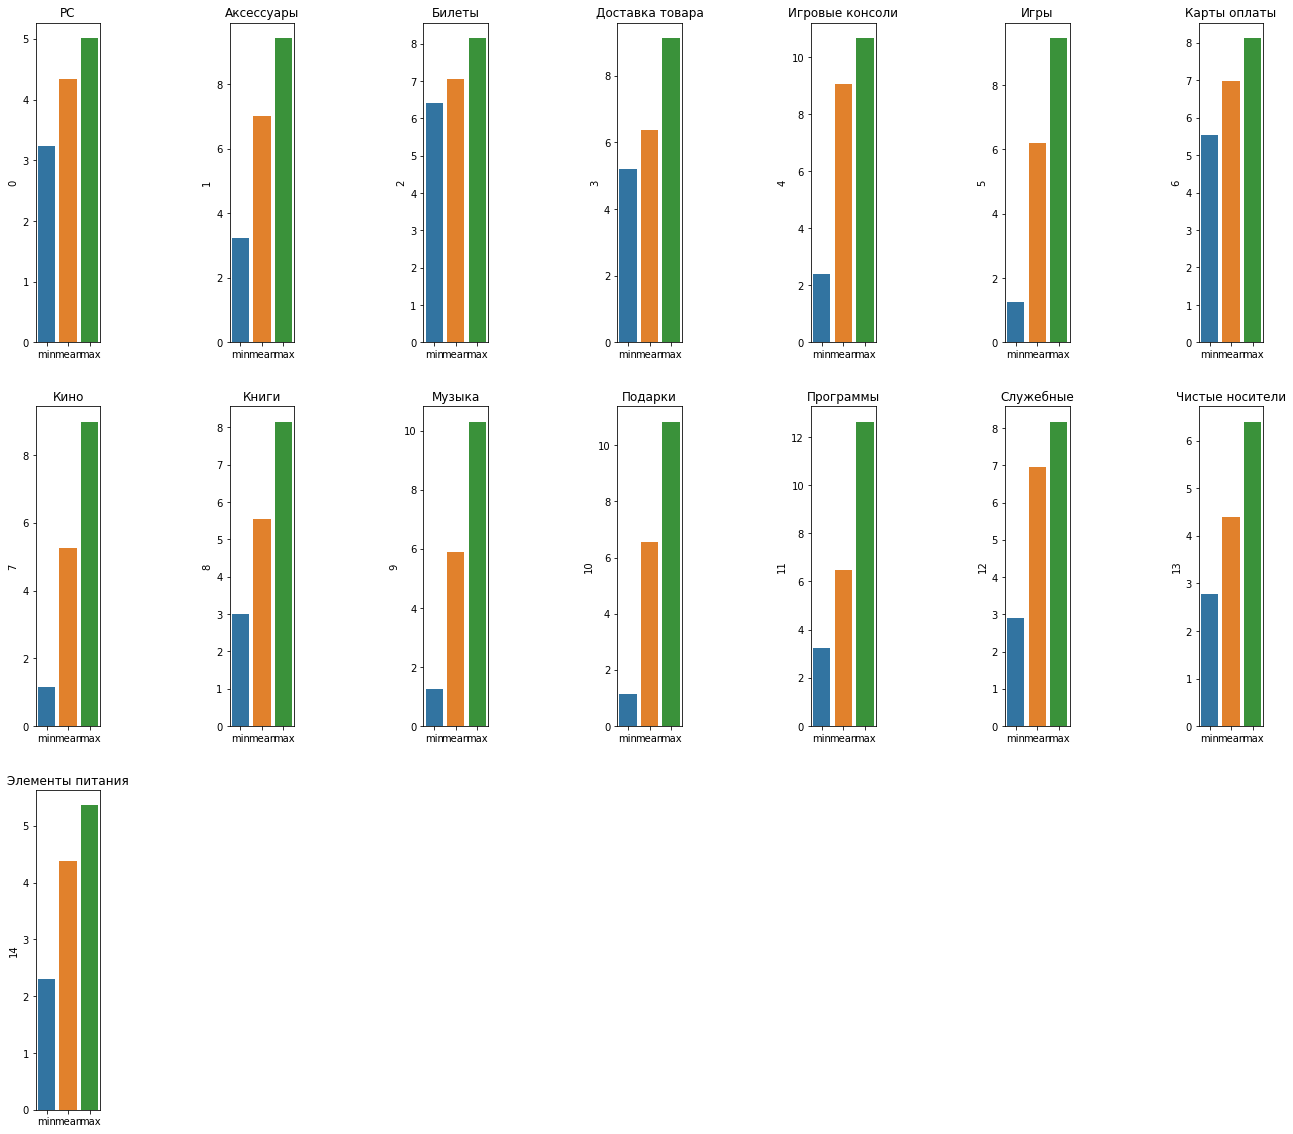

In [ ]:
plt.figure(figsize=(22,20))
plot_cats(cat_price, cats, 3)

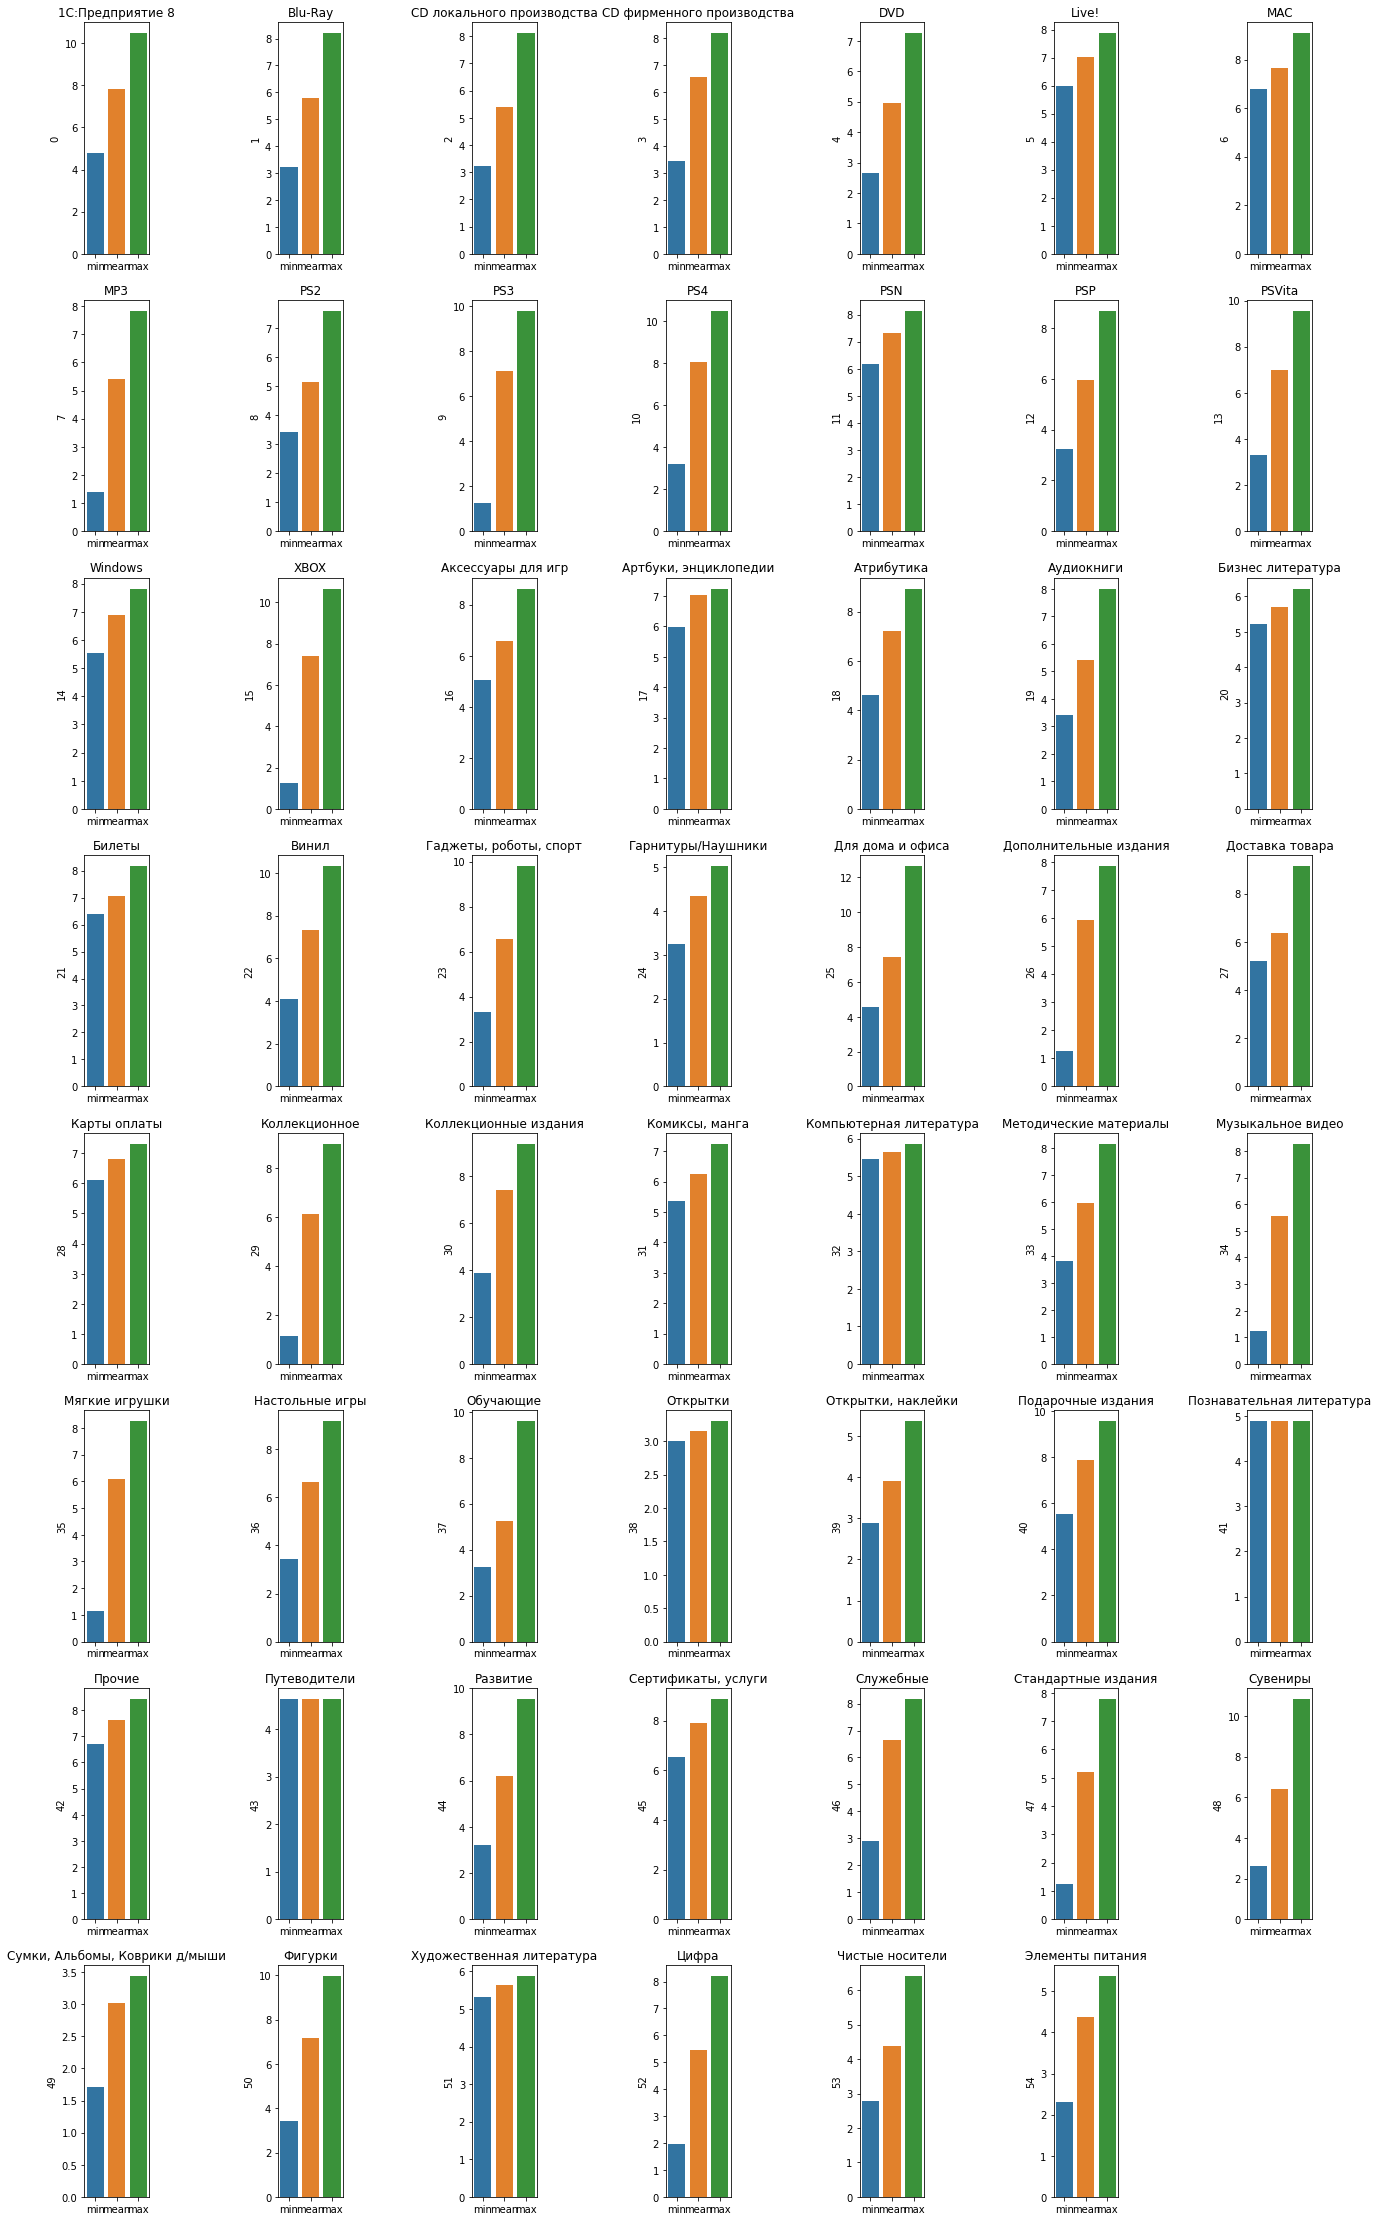

In [ ]:
plt.figure(figsize=(22,40))
plot_cats(sub_cat_price,sub_cats, 8)

# How price affects total count

In [ ]:
item_cnt = pd.DataFrame(data[data.date_block_num >= 24].groupby('item_id')['item_cnt_month'].sum()).reset_index(level = [0])
item_cnt.columns = ['item_id', 'item_cnt_month']
item_cnt.describe([.25, .5, .75, .95]).drop('item_id', axis = 1)

item_cnt_month
count    22170.000000
mean        34.487325
std        302.542732
min         -1.000000
25%          0.000000
50%          1.000000
75%         12.000000
95%        154.000000
max      38606.000000

In [ ]:
item_price_mean = pd.DataFrame(data[data.date_block_num >= 24].groupby('item_id')['item_price'].mean()).reset_index(level = [0])
temp = pd.merge(item_cnt, item_price_mean, on = 'item_id')

temp.columns = ['item_id', 'item_cnt_total', 'item_price']

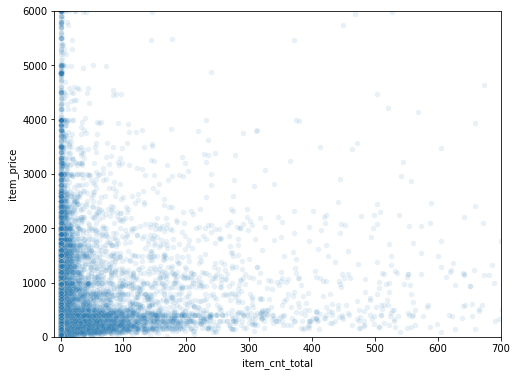

In [ ]:
plt.figure(figsize=(8,6))
sc = sns.scatterplot(x = temp.item_cnt_total, y = temp.item_price, x_bins = [0, 50, 100], alpha = 0.1, s = 30)
sc.set_xlim(left=-10, right=700)
sc.set_ylim(bottom=0, top=6000);

# Total sells through time

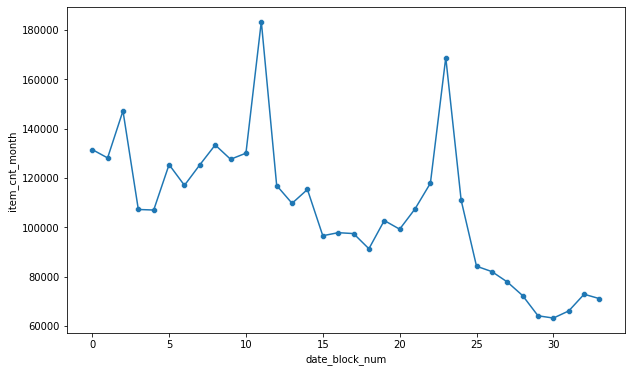

In [ ]:
temp = data.groupby('date_block_num')['item_cnt_month'].sum()
temp.name = 'item_cnt_month'
plt.figure(figsize=(10,6))
sns.scatterplot(y = temp,x = temp.index)
plt.plot(temp.index, temp)
plt.show()

# Count months for each item

In [ ]:
month_count_item = pd.DataFrame(sales.groupby(['item_id', 'date_block_num'])['item_cnt_day'].sum()).reset_index(level = [0,1])
month_count_item.columns = ['item_id', 'date_block_num', 'item_cnt_month']

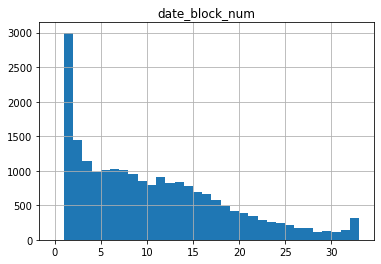

In [ ]:
item_month = pd.DataFrame(month_count_item.groupby('item_id')['date_block_num'].count())
item_month.hist(bins = list(range(34)))
plt.show()

In [ ]:
len(item_month), len(items)

(21807, 22170)

In [ ]:
item_month.columns = ['month_count']
item_month.reset_index(level = [0])
temp  = pd.merge(items, item_month, how = 'left', on = 'item_id')
item_month = temp.fillna(0)

In [ ]:
not_sold_items = item_month[item_month.month_count == 0].month_count

In [ ]:
test_data = pd.read_csv('test.csv')

In [ ]:
test_data[test_data.item_id.isin(not_sold_items.index)]

ID  shop_id  item_id
1            1        5     5320
4            4        5     5268
45          45        5     5826
64          64        5     3538
65          65        5     3571
...        ...      ...      ...
214130  214130       45    15033
214150  214150       45     7572
214154  214154       45     9030
214161  214161       45     1867
214173  214173       45    12470

[15246 rows x 3 columns]

363 items were not sold at all

# Dollar influence

In [ ]:
price_time_mean = data.groupby('date_block_num')['item_price'].mean()
#price_time_median = sales.groupby('date_block_num')['item_price'].median()
price_time_mean = pd.DataFrame(price_time_mean).reset_index(level=[0])
#price_time_median = pd.DataFrame(price_time_median).reset_index(level=[0])

In [ ]:
def plot(a,b):
    plt.figure(figsize=(10,6))
    sns.scatterplot(y = a,x = a.index)
    plt.plot(a.index, a)
    sns.scatterplot(y = b,x =b.index)
    plt.plot(b.index, b)
    plt.show()

In [ ]:
rub = pd.read_csv('rub.csv').reset_index(level=[0])
rub.rub = [float(x.split(' ')[0]) for x in rub.rub]
rub.columns=['date_block_num', 'rub']

In [ ]:
data_month = pd.DataFrame(data.groupby('date_block_num')['item_cnt_month'].sum())
data_month.columns = ['item_cnt_month']
data_month = data_month.reset_index([0])
a = pd.merge(data_month, rub, on = 'date_block_num')
b = pd.merge(a, price_time_mean)

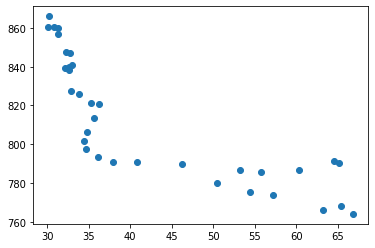

In [ ]:
plt.scatter(rub.rub, price_time_mean.item_price)

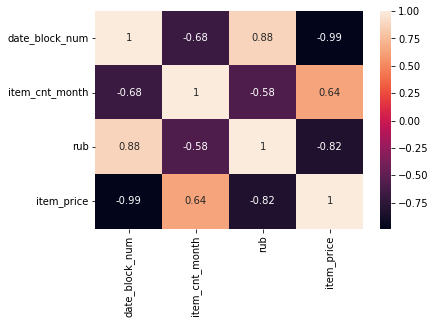

In [ ]:
sns.heatmap(b.corr(), annot=True)

In [ ]:
cat_count = data.groupby(['sub_cat', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1]).fillna(0)
temp = data.groupby(['sub_cat', 'date_block_num'])[['item_price']].mean().reset_index([0,1])

In [ ]:
cat_count = pd.merge(cat_count, temp, on = ['date_block_num', 'sub_cat'])
cat_count = cat_count.groupby('sub_cat')

In [ ]:
for i, c in enumerate(sub_cats):
    t = cat_count.get_group(c)
    t = pd.merge(t,rub, on = 'date_block_num', how = 'right')
    print(c)
    print(t.corr().fillna(0))
    print()

Гарнитуры/Наушники
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.480916         0.0  0.882056
item_cnt_month       -0.480916        1.000000         0.0 -0.293191
item_price            0.000000        0.000000         0.0  0.000000
rub                   0.882056       -0.293191         0.0  1.000000

PS2
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.406924         0.0  0.882056
item_cnt_month       -0.406924        1.000000         0.0 -0.235068
item_price            0.000000        0.000000         0.0  0.000000
rub                   0.882056       -0.235068         0.0  1.000000

PS3
                date_block_num  item_cnt_month  item_price       rub
date_block_num        1.000000       -0.720463   -0.993737  0.882056
item_cnt_month       -0.720463        1.000000    0.688976 -0.626287
item_price           -0.993737        0.688976    1.000000 -0.856233
rub  

# Mean price in categories through time

In [ ]:
m = pd.DataFrame({'date_block_num' : list(range(34))})

In [ ]:
def plot_cat_time(cat_time, cats, name, cat_name, count = False):
    for i, c in enumerate(cats):
        t = cat_time[cat_time[cat_name] == c]
        #print(t.isna().sum())
        t['rolling_avg2'] = t[name].rolling(2).mean()
        t['rolling_avg4'] = t[name].rolling(4).mean()
        plt.subplot(len(cats)//2 + 1,2, i+1)
        X = t.date_block_num.tolist()
        Y = t[name].tolist()
        sns.scatterplot(x = X, y = Y)
        plt.plot( X, Y)
        if count:
            text = t.item_id.tolist()
            for i in range(0,len(t),2):
                plt.annotate(text[i], (X[i], Y[i]+2), fontsize = 10)
        sns.lineplot( x = 'date_block_num', y = 'rolling_avg2', data = t)
        sns.lineplot( x = 'date_block_num', y = 'rolling_avg4', data = t)
        plt.title(c)

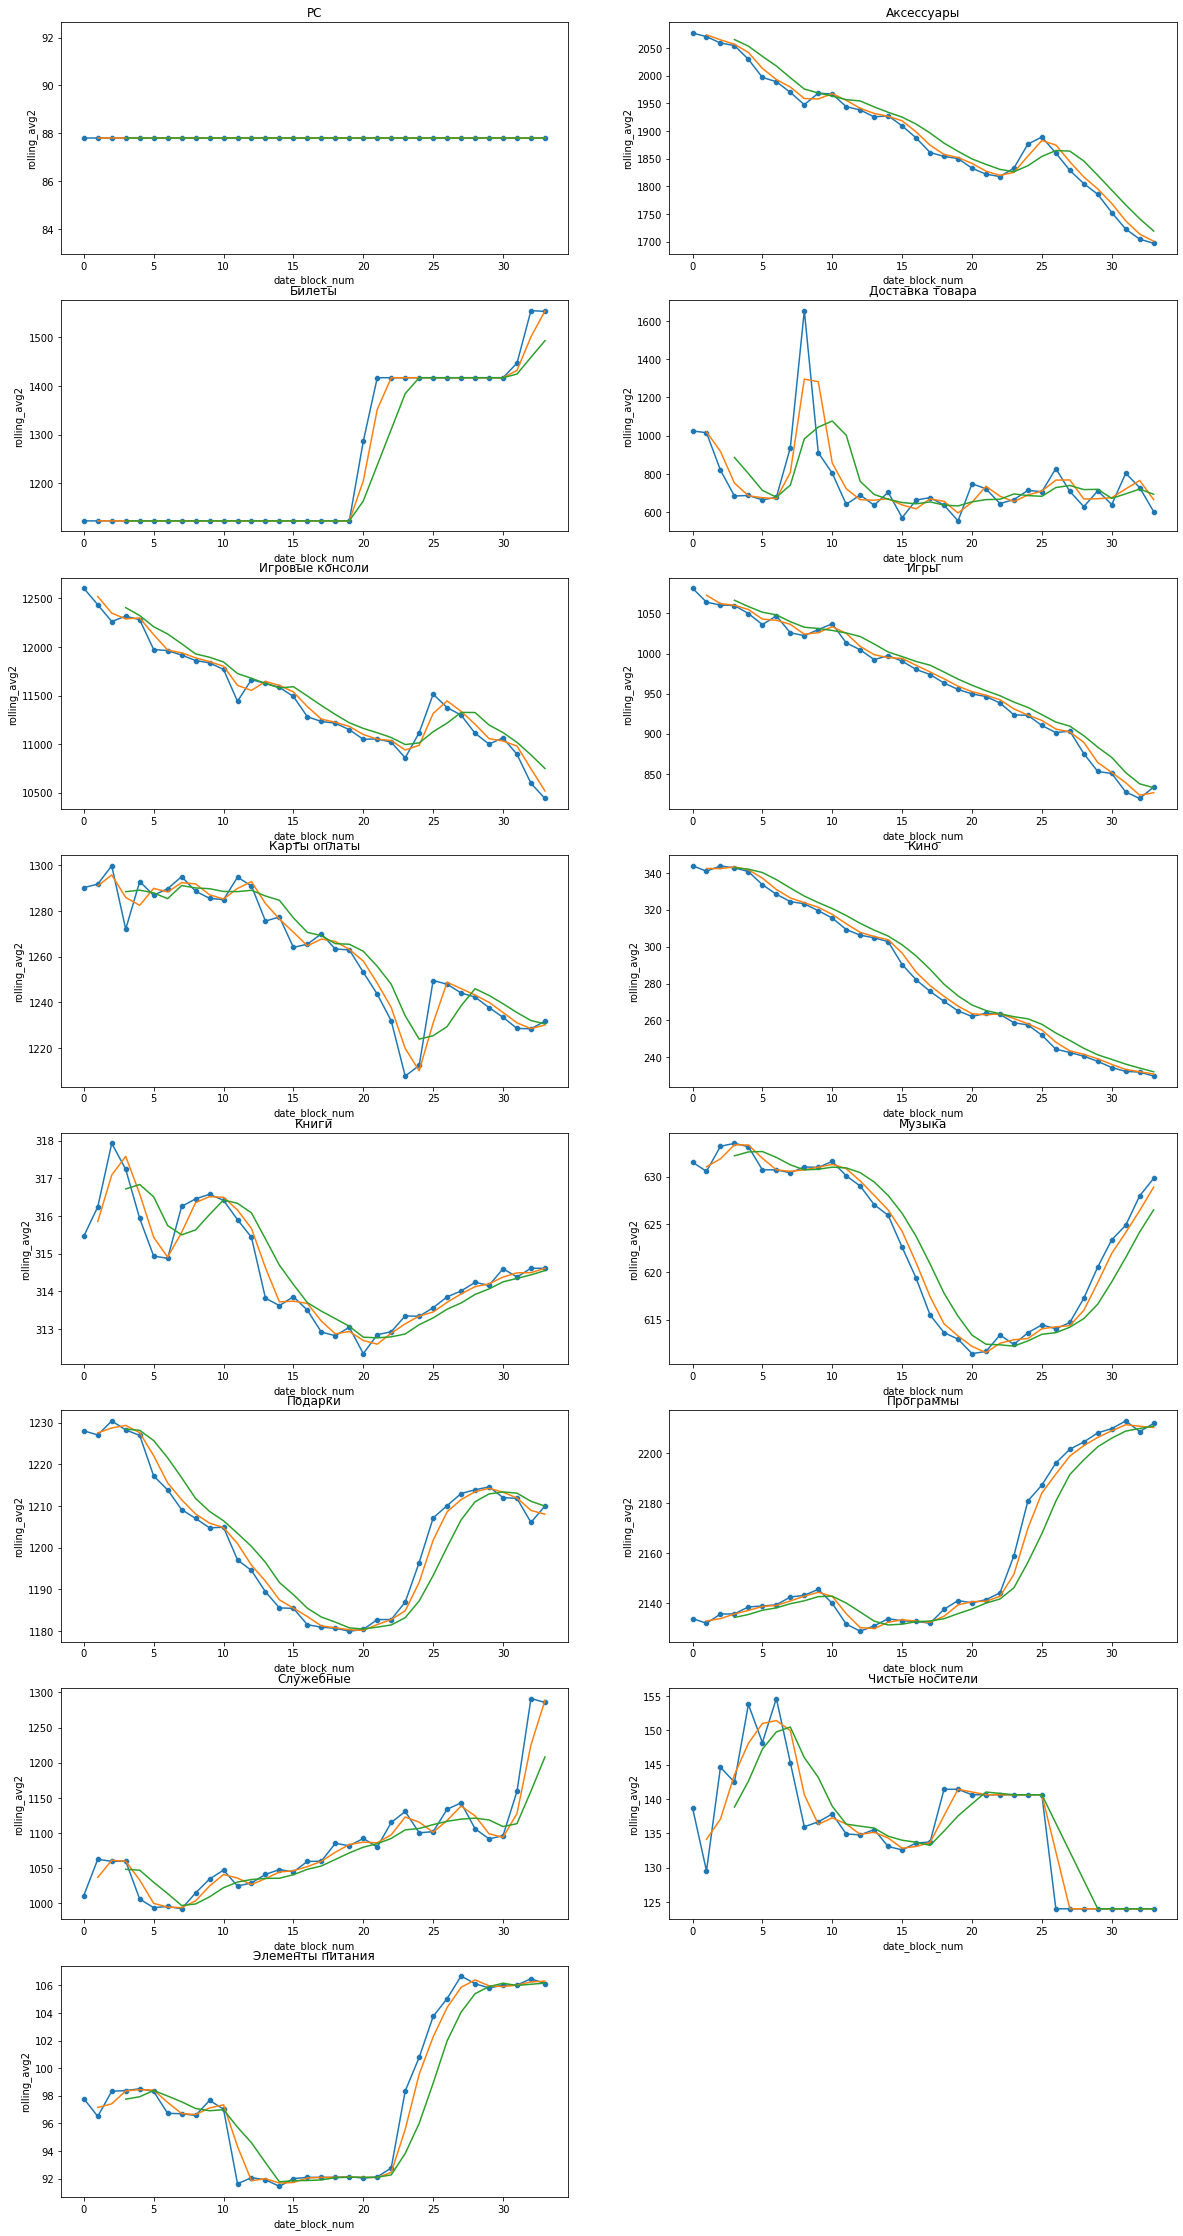

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
item_count = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_id'].nunique()).reset_index(level=[0,1])
cat_time = pd.merge(cat_time, item_count, on = ['cat','date_block_num'])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_price', 'cat')

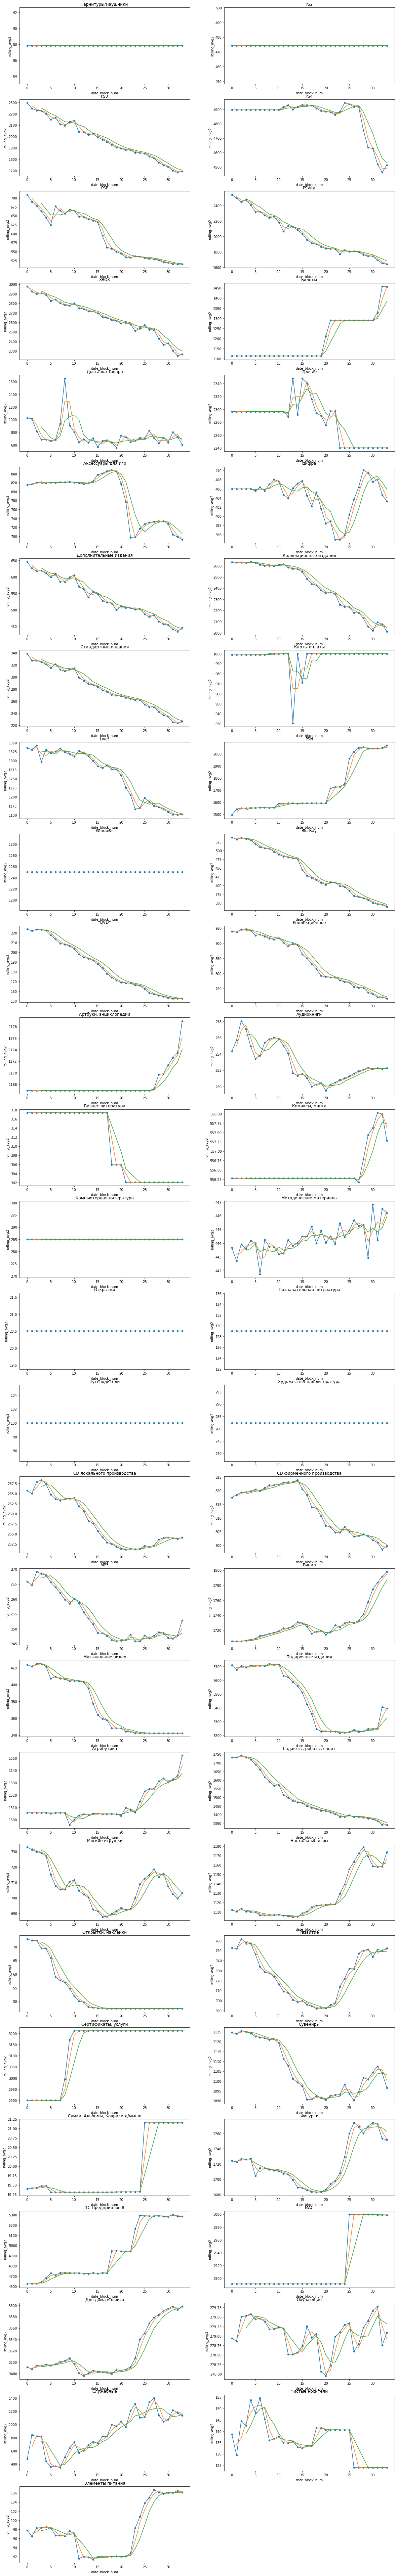

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_price'].mean()).reset_index(level=[0,1])
item_count = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_id'].nunique()).reset_index(level=[0,1])
cat_time = pd.merge(cat_time, item_count, on = ['sub_cat','date_block_num'])
plt.figure(figsize=(20,140))
plot_cat_time(cat_time, sub_cats, 'item_price', 'sub_cat')

# item_count_month in categories through time

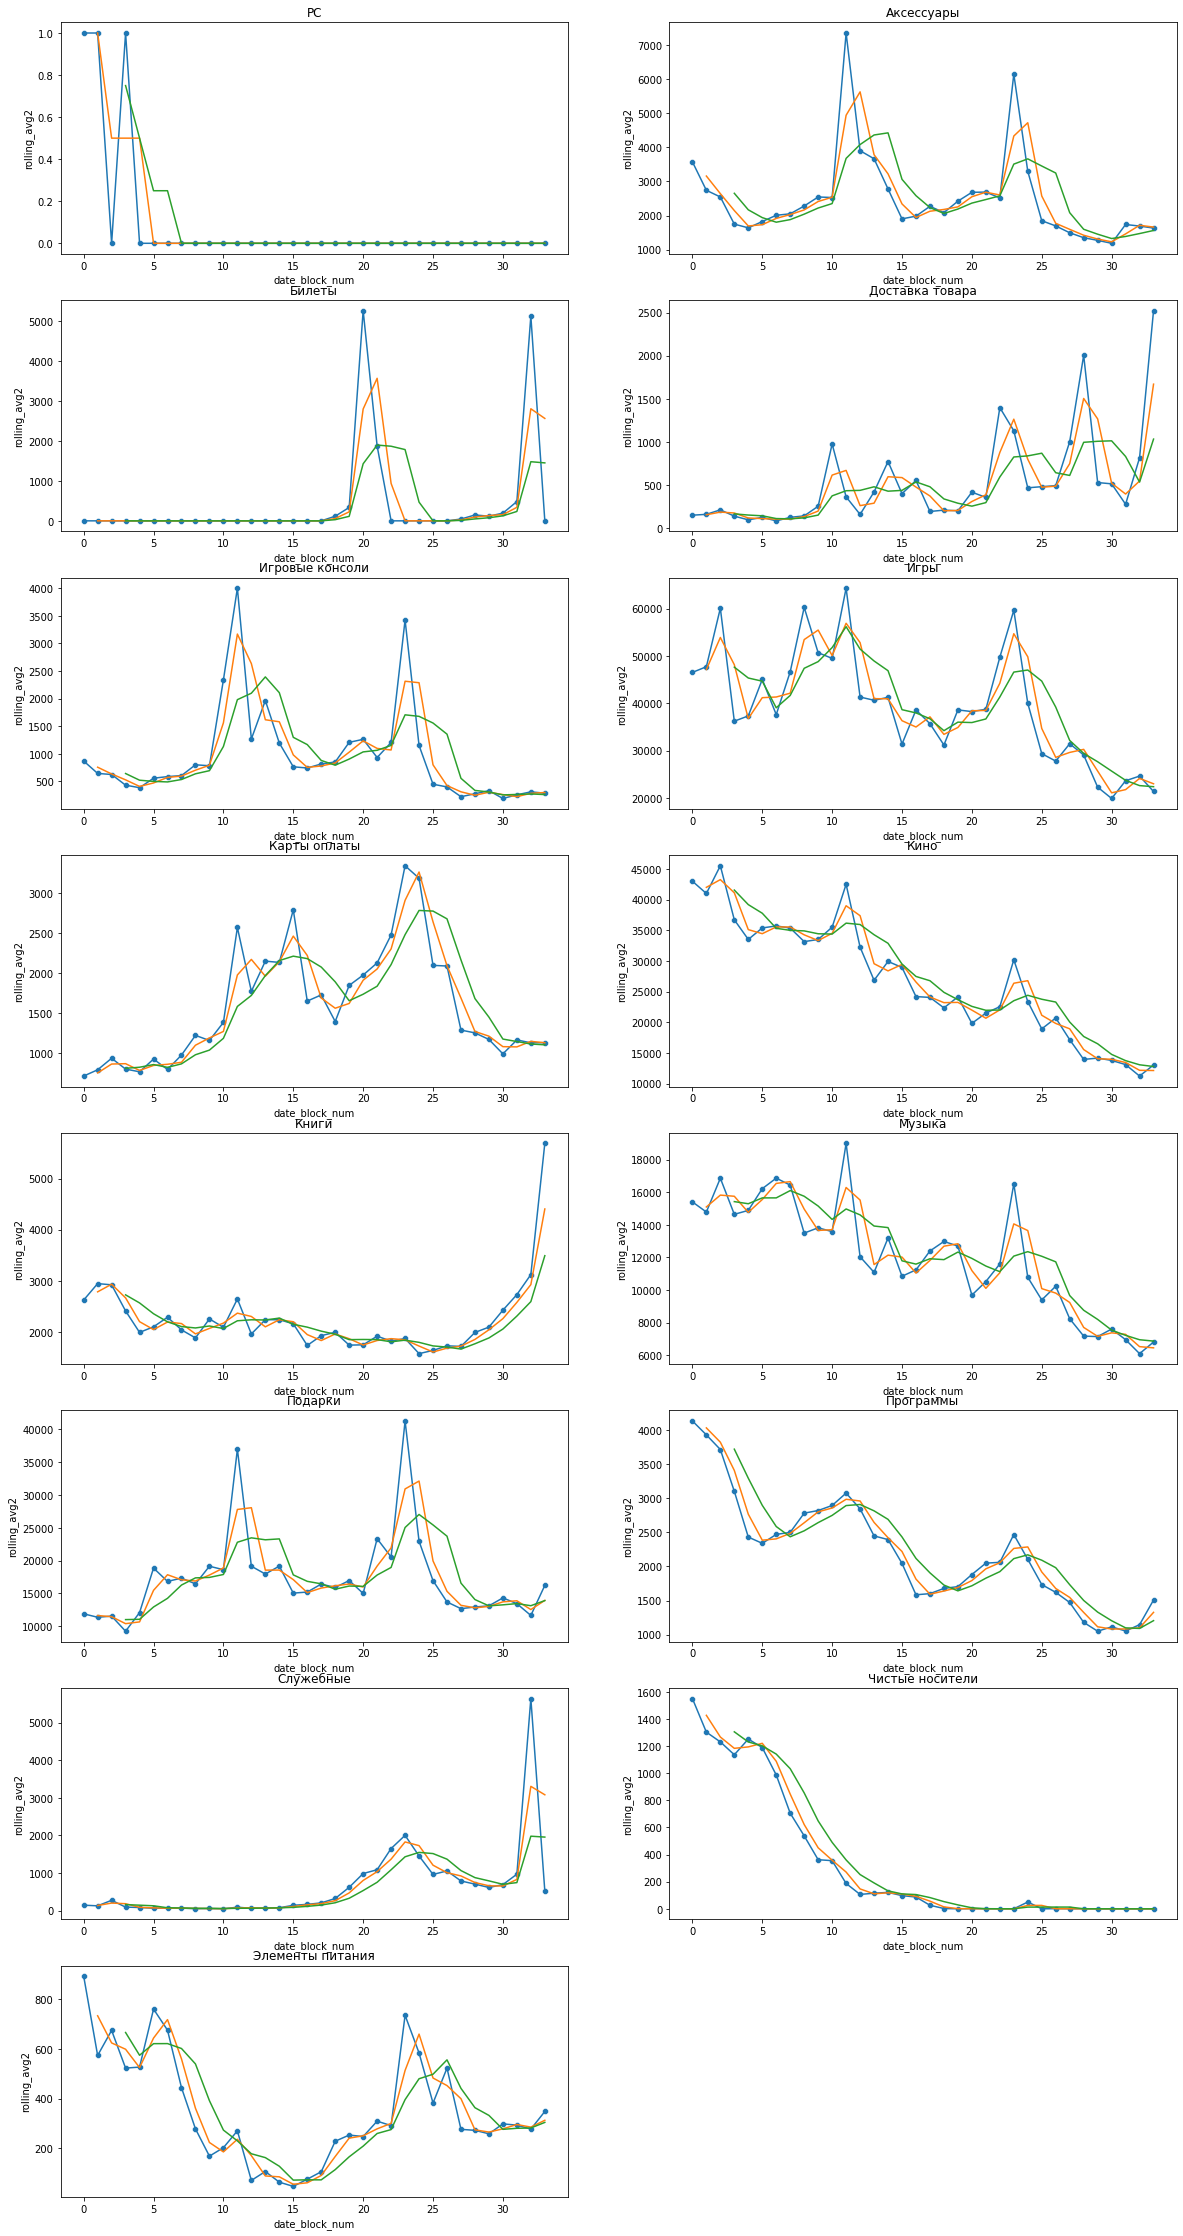

In [ ]:
cat_time = pd.DataFrame(data.groupby(['cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,40))
plot_cat_time(cat_time, cats, 'item_cnt_month', 'cat')

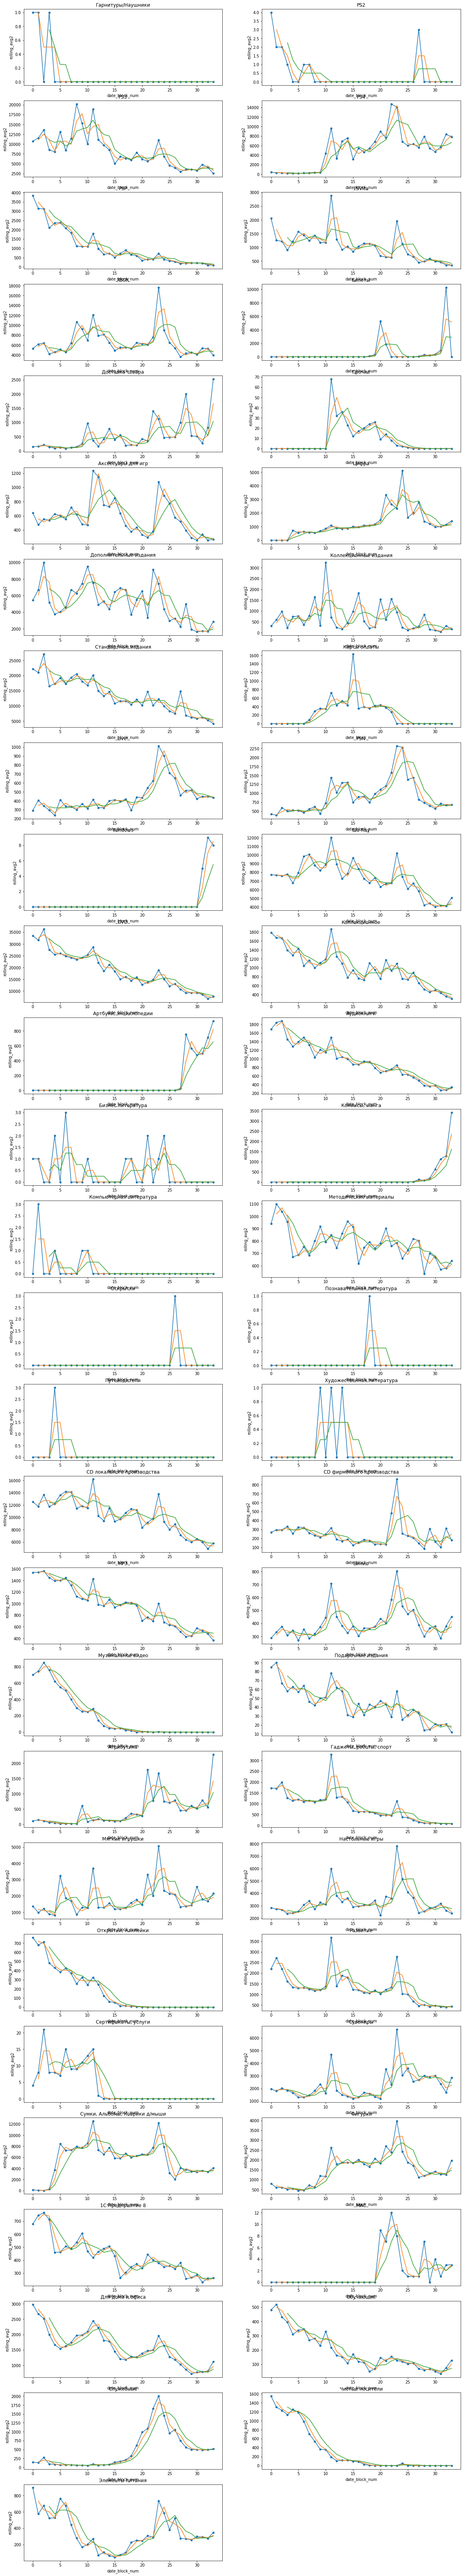

In [ ]:
cat_time = pd.DataFrame(data.groupby(['sub_cat','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,120))
plot_cat_time(cat_time, sub_cats, 'item_cnt_month', 'sub_cat')

# City sells througth time

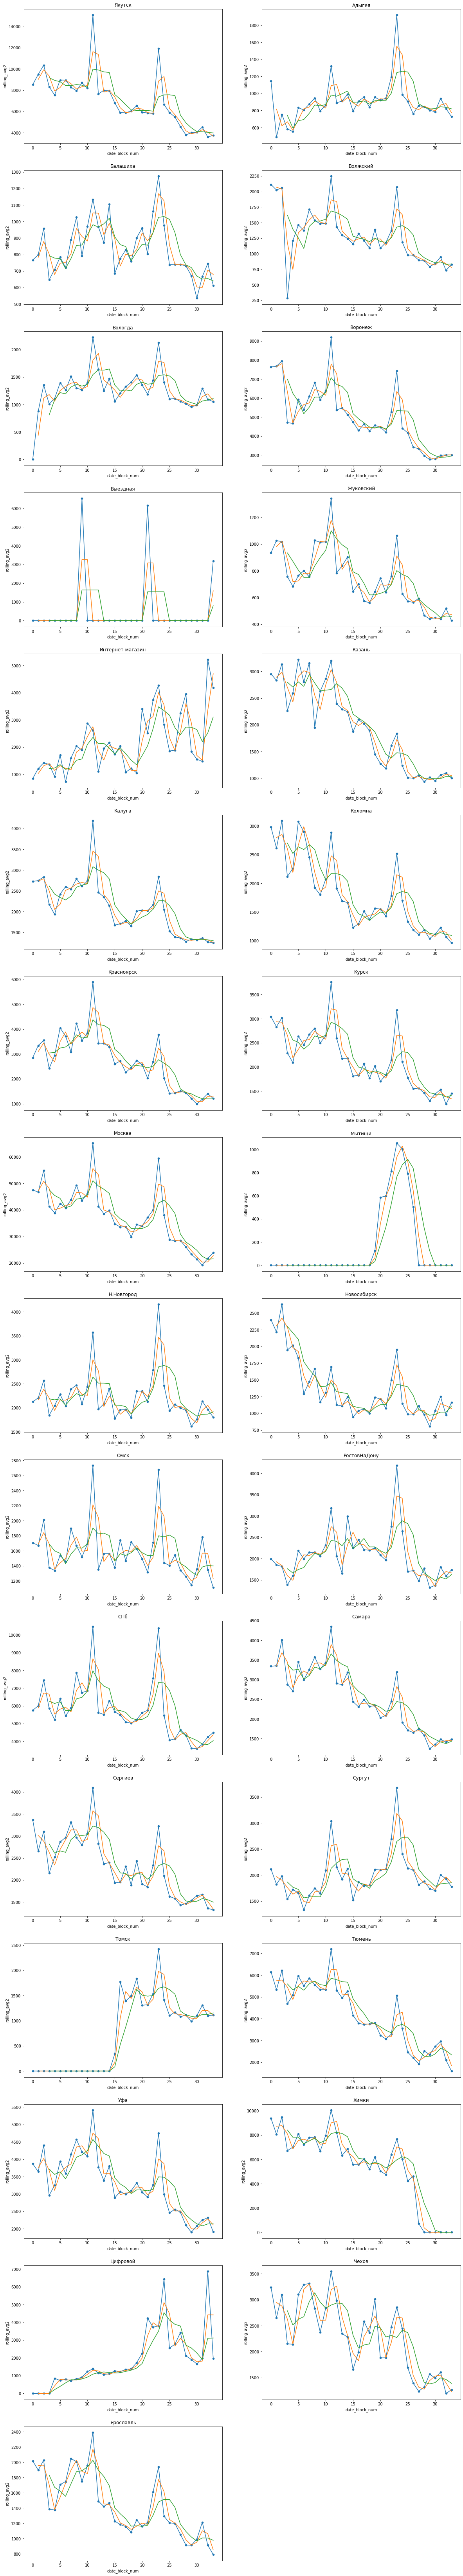

In [ ]:
shop_time = pd.DataFrame(data.groupby(['city','date_block_num'])['item_cnt_month'].sum()).reset_index(level=[0,1])
plt.figure(figsize=(20,120))
plot_cat_time(shop_time, cities, 'item_cnt_month', 'city')

# Shops opened/closed

In [ ]:
first_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].min()).reset_index([0]).sort_values('date')
last_date_shop = pd.DataFrame(sales.groupby('shop_id')['date'].max()).reset_index([0]).sort_values('date')

In [ ]:
last_date_shop[last_date_shop.date < datetime(2015, 10, 10)]

shop_id       date
0         0 2013-02-28
1         1 2013-02-28
8         8 2013-04-01
23       23 2013-04-28
32       32 2013-07-03
13       13 2014-08-09
17       17 2015-01-18
43       43 2015-01-25
40       40 2015-01-29
30       30 2015-02-18
11       11 2015-02-28
54       54 2015-04-23
33       33 2015-04-24
29       29 2015-05-28
51       51 2015-09-28
27       27 2015-09-30
20       20 2015-10-04

In [ ]:
closed_shops = last_date_shop[last_date_shop.date < datetime(2015, 10, 30)].shop_id

# Random item sells

In [ ]:
m = pd.DataFrame({'date_block_num':list(range(34))})

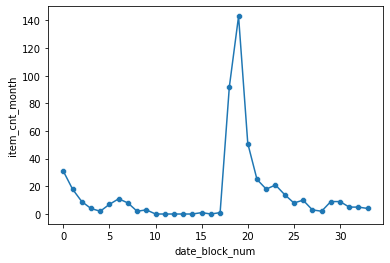

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]

sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_month'].sum()).reset_index([0])


a = pd.merge(sample,m, on = 'date_block_num', how = 'right').fillna(0)

sns.scatterplot(x = a.date_block_num,y = a.item_cnt_month)
plt.plot( a.date_block_num, a.item_cnt_month)

# Random item price change

PS4: Комплект 4gamers Gaming Headset Starter Kit (гарнитура стерео, двойной зарядный кабель (4G-4882)


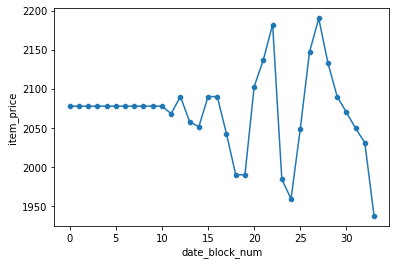

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]
print(sample.item_name.iloc[0])
sample = pd.DataFrame(sample.groupby('date_block_num')['item_price'].mean()).reset_index([0])
sns.scatterplot(x = sample.date_block_num,y = sample.item_price)
plt.plot(sample.date_block_num, sample.item_price)
plt.show()

In [ ]:
items[items.item_name == 'МУЖИКИ! (регион)']

item_name  item_id  item_category_id
14856  МУЖИКИ! (регион)    14856                40

# Population

In [ ]:
population = pd.read_csv('population.csv', encoding="cp1251", delimiter=';')
population = pd.merge(population, shops[['city']], on='city', how='right').drop_duplicates('city')
population 

city      pop
0             Якутск    299.0
2             Адыгея    449.0
3           Балашиха    260.0
4           Волжский    326.0
5            Вологда    318.0
6            Воронеж   1023.0
9           Выездная      NaN
10         Жуковский    107.0
12  Интернет-магазин      NaN
13            Казань   1205.0
15            Калуга    359.0
16           Коломна    144.0
17        Красноярск   1052.0
19             Курск    435.0
20            Москва  12197.0
33            Мытищи    187.0
34        Н.Новгород   1267.0
36       Новосибирск   1567.0
38              Омск   1173.0
39      РостовНаДону   1114.0
42               СПб   5191.0
44            Самара   1171.0
46           Сергиев    106.0
47            Сургут    340.0
48             Томск    564.0
49            Тюмень    697.0
52               Уфа   1105.0
54             Химки    232.0
55          Цифровой      NaN
56             Чехов     69.0
59         Ярославль    603.0

In [ ]:
cities_total = data.groupby(['city', 'date_block_num'])['item_cnt_month'].sum().reset_index([0,1])
cities_total = cities_total.groupby('city')['item_cnt_month'].mean()
cities_total = pd.merge(cities_total, population, on = 'city')
pred = cities_total[cities_total['pop'].isnull()]
cities_total = cities_total.dropna()

In [ ]:
cities_total.corr()

item_cnt_month       pop
item_cnt_month        1.000000  0.922689
pop                   0.922689  1.000000

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
X = cities_total.item_cnt_month.values
y = cities_total['pop'].values

In [ ]:
lr = LinearRegression()
lr.fit(X.reshape(-1, 1),y)
pred['pop'] = lr.predict(np.array(pred.item_cnt_month).reshape(-1, 1) )
pred

city  item_cnt_month         pop
5           Выездная      466.647059  177.785061
7   Интернет-магазин     2161.117647  717.459027
27          Цифровой     1864.352941  622.942081

In [ ]:
population = pd.concat((population.dropna(), pred.drop(['item_cnt_month'], axis = 1)))
population

city           pop
0             Якутск    299.000000
2             Адыгея    449.000000
3           Балашиха    260.000000
4           Волжский    326.000000
5            Вологда    318.000000
6            Воронеж   1023.000000
10         Жуковский    107.000000
13            Казань   1205.000000
15            Калуга    359.000000
16           Коломна    144.000000
17        Красноярск   1052.000000
19             Курск    435.000000
20            Москва  12197.000000
33            Мытищи    187.000000
34        Н.Новгород   1267.000000
36       Новосибирск   1567.000000
38              Омск   1173.000000
39      РостовНаДону   1114.000000
42               СПб   5191.000000
44            Самара   1171.000000
46           Сергиев    106.000000
47            Сургут    340.000000
48             Томск    564.000000
49            Тюмень    697.000000
52               Уфа   1105.000000
54             Химки    232.000000
56             Чехов     69.000000
59         Ярославль    603.000000
5           Выездная    177.785061
7   Интернет-магазин    717.459027
27          Цифровой    622.942081

In [ ]:
population.to_csv('population_full.csv', sep=';')

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num','city', 'shop_id'])[['item_cnt_month']].sum().reset_index([0,1,2])
city_month = pd.merge(city_month, population, on = 'city', how = 'left')
city_month.drop(['date_block_num', 'shop_id'], axis = 1).corr()

item_cnt_month       pop
item_cnt_month        1.000000  0.261343
pop                   0.261343  1.000000

In [ ]:
city_month = data[data.date_block_num >=28].groupby(['date_block_num','city'])[['item_cnt_month']].sum().reset_index([0,1])
city_month = pd.merge(city_month, population, on = 'city', how = 'left')
city_month.drop(['date_block_num'], axis = 1).corr()

item_cnt_month       pop
item_cnt_month        1.000000  0.923966
pop                   0.923966  1.000000

# Number of shops

In [ ]:
temp = data[data.date_block_num >=28].groupby(['city', 'date_block_num'])[['shop_id']].nunique()
temp.columns = ['shop_cnt']
temp = temp.reset_index([0,1])

In [ ]:
pd.merge(city_month,temp, on = ['city', 'date_block_num']).corr()

date_block_num  item_cnt_month           pop      shop_cnt
date_block_num    1.000000e+00        0.009231  5.373801e-17  9.280530e-17
item_cnt_month    9.230767e-03        1.000000  9.277170e-01  9.386310e-01
pop               5.373801e-17        0.927717  1.000000e+00  8.864807e-01
shop_cnt          9.280530e-17        0.938631  8.864807e-01  1.000000e+00

# City - category

In [ ]:
temp = data.groupby(['city','cat' ])['item_cnt_month'].sum().reset_index([0,1])

In [ ]:
cities = pd.unique(shops.city)

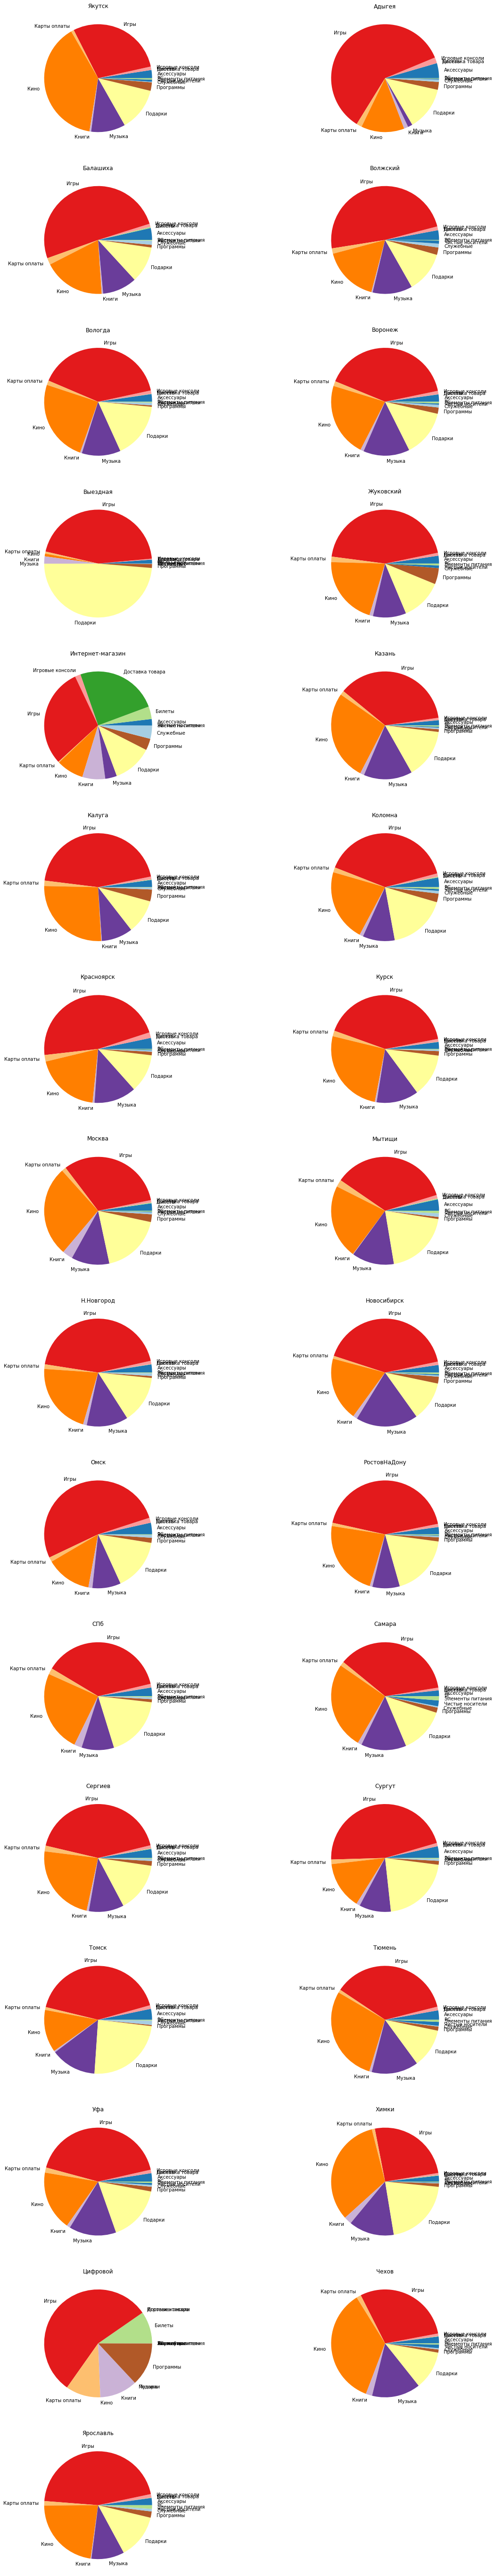

In [ ]:
plt.figure(figsize=(20,100))
colors = sns.color_palette('Paired')[:len(cats)]
for i, c in enumerate(cities):
        t = temp.groupby('city').get_group(c)
        plt.subplot(len(cities)//2 + 1,2, i+1)
        plt.pie(t.item_cnt_month,labels=t.cat, colors=colors)
        plt.title(c)

# Sells in closed shops

In [ ]:
temp = sales[sales.shop_id.isin(closed_shops)].groupby(['shop_id', 'date_block_num'])[['item_cnt_day']].sum().groupby('shop_id')

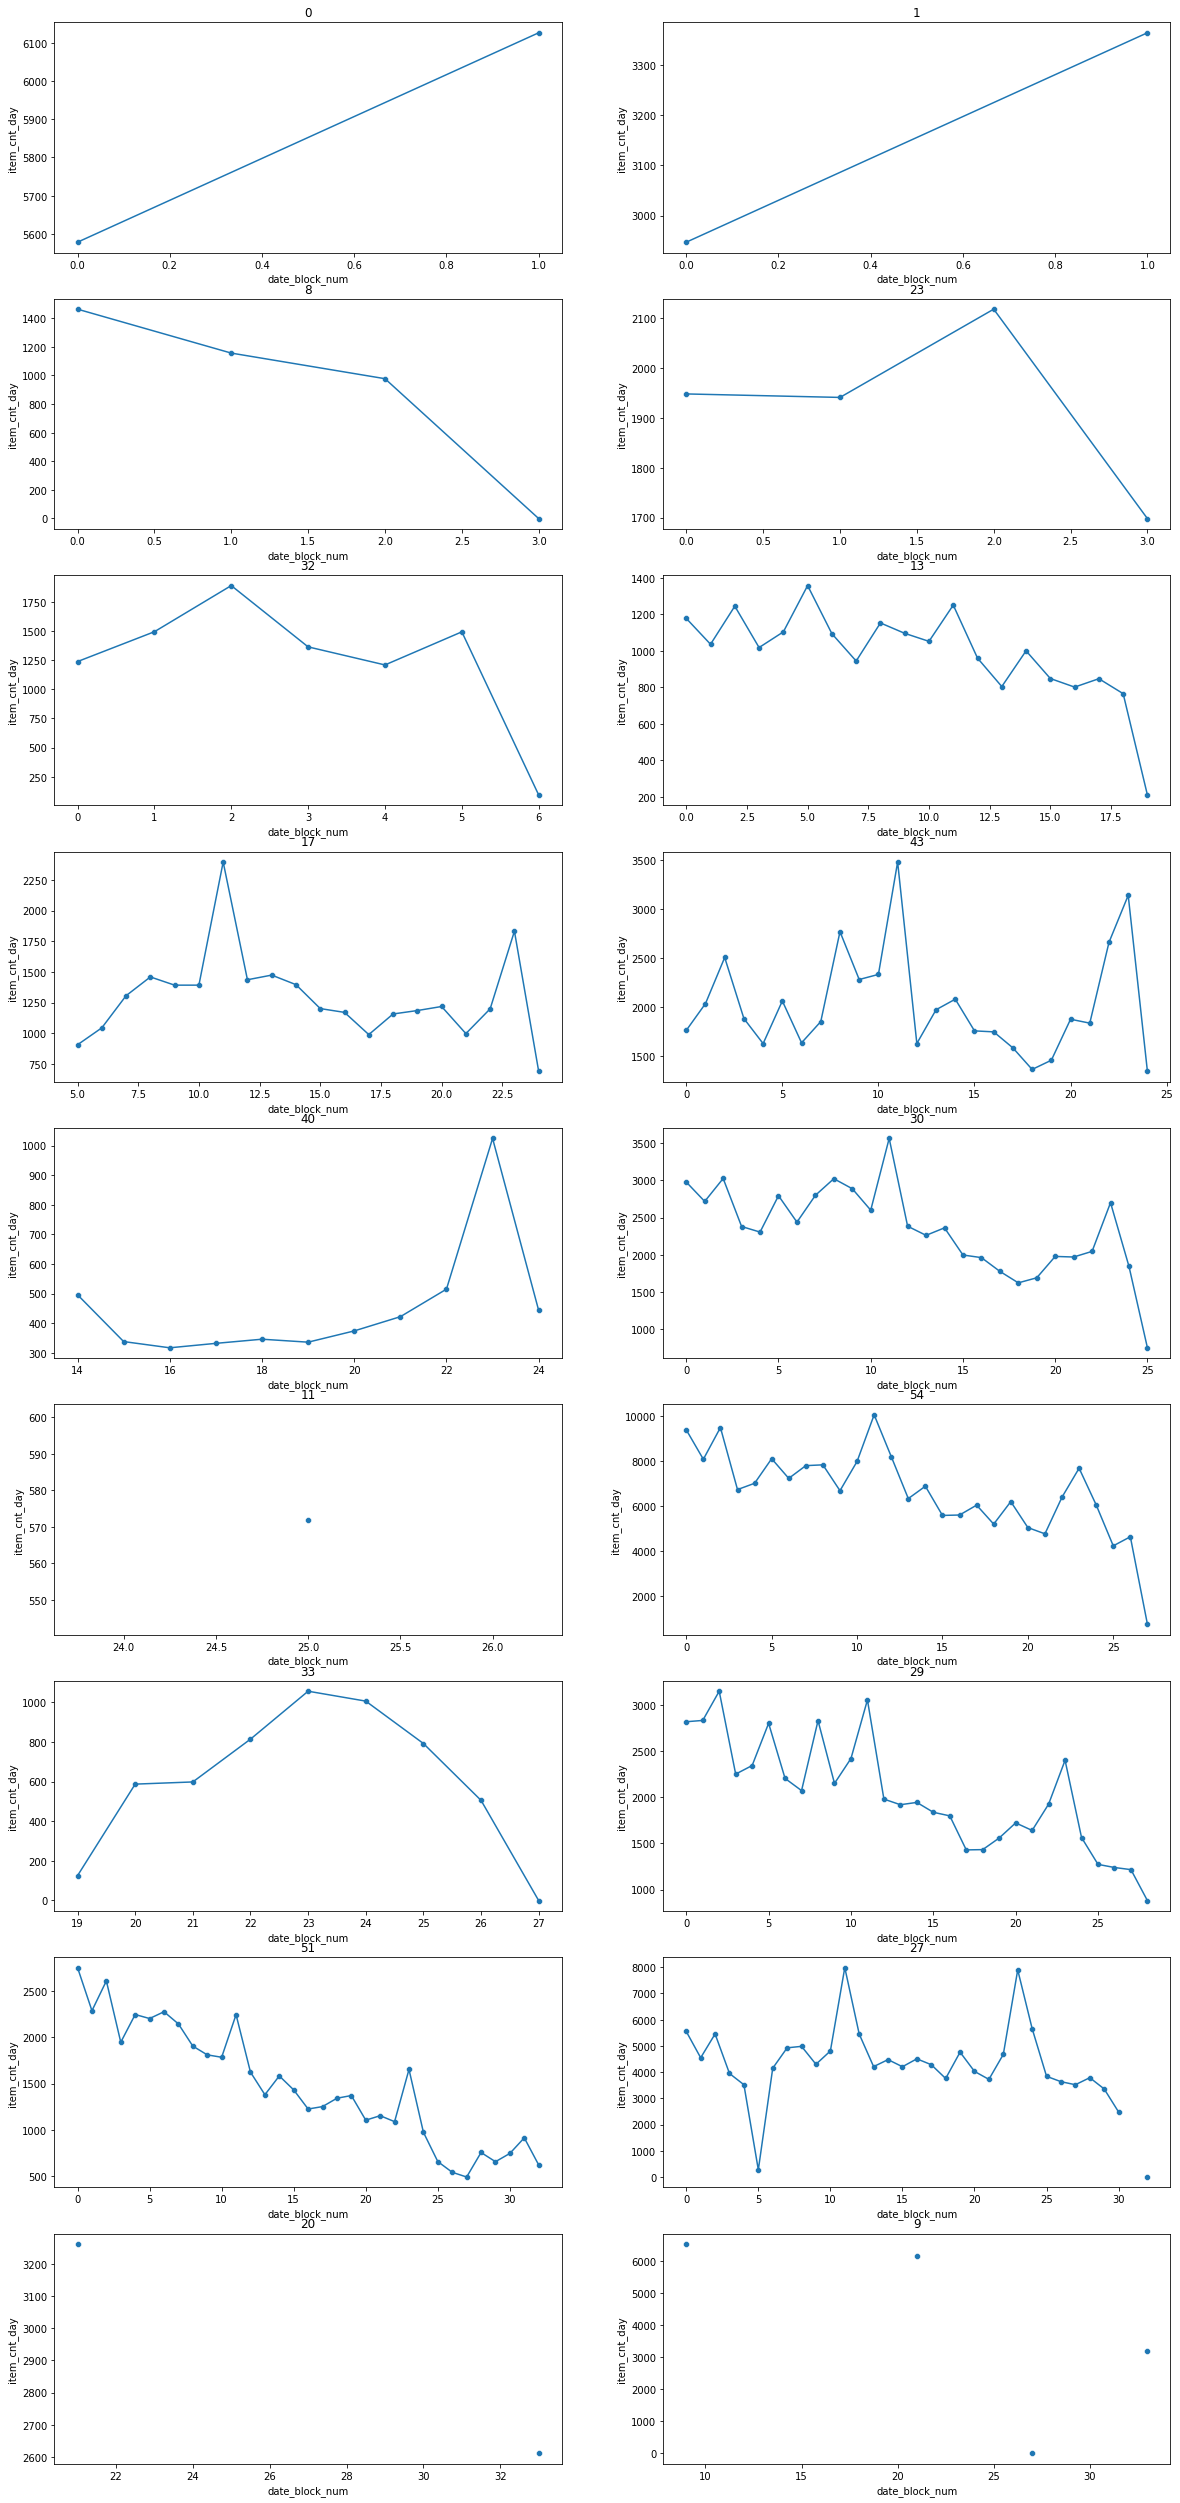

In [ ]:
plt.figure(figsize=(20,50))
for i, s in enumerate(closed_shops):
    t = temp.get_group(s)
    t = pd.merge(t, m, on = 'date_block_num', how = 'right')
    plt.subplot(len(closed_shops)//2 + 1,2, i+1)
    sns.scatterplot(x = t.date_block_num,y = t['item_cnt_day'])
    plt.plot( t.date_block_num, t['item_cnt_day'])
    plt.title(s)

In [ ]:
shops[shops.shop_id.isin(closed_shops)]

shop_name  shop_id          city
0                      Якутск Орджоникидзе, 56 фран        0        Якутск
1                      Якутск ТЦ "Центральный" фран        1        Якутск
8                      Воронеж ТРЦ Сити-Парк "Град"        8       Воронеж
9                                 Выездная Торговля        9      Выездная
11                       Жуковский ул. Чкалова 39м²       11     Жуковский
13                              Казань ТЦ "Бехетле"       13        Казань
17                    Красноярск ТЦ "Взлетка Плаза"       17    Красноярск
20                              Москва "Распродажа"       20        Москва
23                 Москва ТК "Буденовский" (пав.А2)       23        Москва
27                   Москва ТЦ "МЕГА Белая Дача II"       27        Москва
29               Москва ТЦ "Новый век" (Новокосино)       29        Москва
30                           Москва ТЦ "Перловский"       30        Москва
32                       Москва ТЦ "Серебряный Дом"       32        Москва
33                                Мытищи ТРК "XL-3"       33        Мытищи
40  РостовНаДону ТРК "Мегацентр Горизонт" Островной       40  РостовНаДону
43                                  СПб ТК "Сенная"       43           СПб
51                        Тюмень ТЦ "Зеленый Берег"       51        Тюмень
54                                  Химки ТЦ "Мега"       54         Химки

# First and last month of sales

In [ ]:
item_date_points = data[data.item_cnt_month != 0].groupby('item_id').agg({'date_block_num' : ['min', 'max']})
item_date_points.columns = item_date_points.columns.droplevel(0)
item_date_points = pd.merge(item_date_points, items, on = 'item_id', how = 'right').fillna(0)

Text(0.5, 1.0, 'Last month of sales')

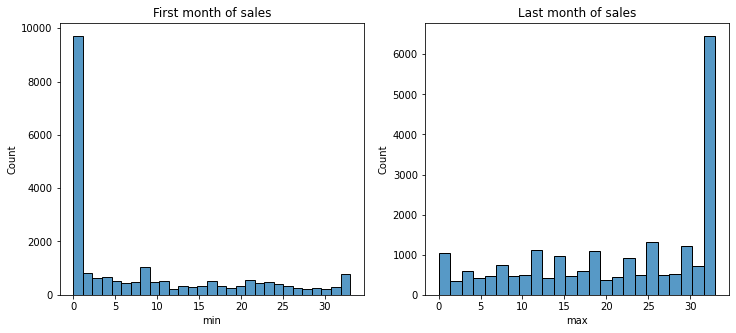

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2, 1)
sns.histplot(data = item_date_points, x = 'min')
plt.title('First month of sales')
plt.subplot(1,2, 2)
sns.histplot(data = item_date_points, x = 'max')
plt.title('Last month of sales')

In [ ]:
item_date_points = 0

In [ ]:
mean_sales_shops = data.groupby(['shop_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('shop_id')[['item_cnt_month']].mean()

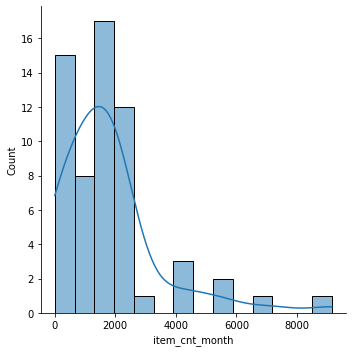

In [ ]:
sns.displot(data = mean_sales_shops, x = 'item_cnt_month' , kde = True)

# Mean sales in shops vs last month sales

In [ ]:
last_month_sales = data[data.date_block_num == 33].groupby('shop_id')[['item_cnt_month']].sum()

In [ ]:
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'shop_id').drop(['shop_id'], axis = 1).corr()

item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.708336
item_cnt_month_y          0.708336          1.000000

In [ ]:
mean_sales_shops = data[data.date_block_num > 28].groupby(['shop_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('shop_id')[['item_cnt_month']].mean()

# Mean sales for the past 4 month vs last month sales

In [ ]:
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'shop_id').drop(['shop_id'], axis = 1).corr()

item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.920399
item_cnt_month_y          0.920399          1.000000

In [ ]:
mean_sales_shops = data[data.date_block_num > 28].groupby(['item_id', 'date_block_num'])[['item_cnt_month']].sum().reset_index([0,1])
mean_sales_shops = mean_sales_shops.groupby('item_id')[['item_cnt_month']].mean()

In [ ]:
last_month_sales = data[data.date_block_num == 33].groupby('item_id')[['item_cnt_month']].sum()

In [ ]:
pd.merge(mean_sales_shops.reset_index([0]), last_month_sales, on = 'item_id').drop(['item_id'], axis = 1).corr()

item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.866606
item_cnt_month_y          0.866606          1.000000

# Last year sales vs this year sales for each month

In [ ]:
data['month'] = (data.date_block_num % 12 + 1).astype(np.int8)

In [ ]:
for random_month in list(range(1,10)):
    group1 = data.groupby(['month', 'date_block_num']).get_group((random_month, random_month + 11))[['item_id', 'shop_id', 'item_cnt_month']]
    group2 = data.groupby(['month', 'date_block_num']).get_group((random_month, random_month + 23))[['item_id', 'shop_id', 'item_cnt_month']]
    c = pd.merge(group1, group2, on = ['item_id', 'shop_id'])[['item_cnt_month_x','item_cnt_month_y']].corr()
    print(random_month)
    print(c)


1
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.560473
item_cnt_month_y          0.560473          1.000000
2
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.427792
item_cnt_month_y          0.427792          1.000000
3
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.243159
item_cnt_month_y          0.243159          1.000000
4
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.231026
item_cnt_month_y          0.231026          1.000000
5
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.454282
item_cnt_month_y          0.454282          1.000000
6
                  item_cnt_month_x  item_cnt_month_y
item_cnt_month_x          1.000000          0.687964
item_cnt_month_y          0.687964          1.000000
7
                  item_cnt_month

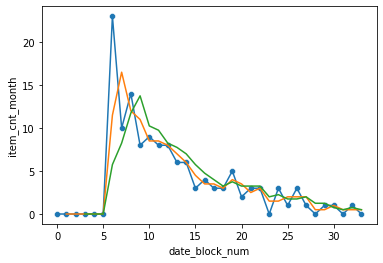

In [ ]:
sample = data[data.item_id == items.sample().iloc[0,1]]
name = 'item_cnt_month'
sample = pd.DataFrame(sample.groupby('date_block_num')['item_cnt_month'].sum()).reset_index([0])
sample['rolling_avg2'] = sample[name].rolling(2).mean()
sample['rolling_avg4'] = sample[name].rolling(4).mean()

#a = pd.merge(sample,m, on = 'date_block_num', how = 'right').fillna(0)

sns.scatterplot(x = sample.date_block_num,y = sample.item_cnt_month)
plt.plot( sample.date_block_num, sample.item_cnt_month)
sns.lineplot( x = 'date_block_num', y = 'rolling_avg2', data = sample)
sns.lineplot( x = 'date_block_num', y = 'rolling_avg4', data = sample)

# Notes

* 363 items were not sold at all
a lot of items were sold only for a short period of time(1 month)
it is necessary to explore this items more carefully(probably we can devide them into categories)

* a lot of outliers in price column and item_cnt_day column
big value of item_cnt_day may be a sign of продажи оптом
they appear in almost all months

* some shops have very low sales number. it may be explained by different opening time. 
maybe a month of opening might be useful for predictions
* some categories have very low sales. it may make sense to unite them into one

* huge variance in price within every category 
the biggest variance is seen in categories with the highest sales. it may be explained by the variety of goods in this category
maybe it would make sence to divide them into smaller categories 

* overall sales tend to decrease an it is clear that there are peaks in december

* dollar correlates well with total item_cnt_month(sum for all items) and mean item_price
but we should be careful because it also correlates with date_block_num

* dollar affects different categories differently

* if we look at the random item count distribution through time we 
will notice that most items were sold only for a short period of time and most items have one peak
maybe we can cluster items by their sales distribution
cause you can notice some patterns and similarities

* some months have strong correlation in sales (min 0.35 max 0.97)
* some months have strong correlation in sales per shop

* some shops were opened after 2013*01 and some were closed before 2015*10
low correlation between some months can be explained by closed and opened shops

* population correlates well with total sells in a city as well as amount of shops in a city

